In [1]:
import netCDF4
import numpy as np
from scipy import stats
import glob
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# This script makes <font color='blue'>Figure 1, Figure 2, and Figure 3
from Penn & Holloway 2020.
    
**Input:** 
- AQS in the folder `AQS_data`
- GOME2 files gridded by WHIPS for each day in the folder `WHIPS-output/GOME2/`
- OMI files gridded by WHIPS for each day in the folder `WHIPS-output/DOMINO/`

**Output:**

The scripts first select only data points which have valid overlapping data for an AQS monitor, GOME-2 pixel, and OMI pixel for each day. Then, various data analysis/plots are made. 

Change the `base_dir` to the folder where you downloaded the GitHub file, and all the scripts should work. 

*Created by Elise Penn; last modified 09/17/2020.*

In [2]:
# CHANGE THIS to match the directory where you put penn_holloway_2020
base_dir = '/Volumes/Space/penn_holloway_github/' #'/Users/Elise/penn_holloway/'

# directories for your WHIPS output
omiDir = '{}WHIPS-output/DOMINO/grid0_25x0_25/'.format(base_dir)
#omiDir = '{}WHIPS-output/DOMINO/grid0_5x0_5/'
go2Dir = '{}WHIPS-output/GOME2/grid0_25x0_25_no_big_pixels/'.format(base_dir)
#go2Dir = '{}WHIPS-output/GOME2/grid0_5x0_5/'

# filename prefixes 
omiPrefix = 'knmi_omi_minPix250_maxPix2100_0_25x0_25_CONUS_' # WHIPS-gridded OMI 0.25x0.25
#omiPrefix = 'knmi_omi_minPix250_maxPix2100_0_5x0_5_CONUS_' # WHIPS-gridded OMI 0.5x0.5
go2Prefix = 'nobigpixels_' # WHIPS-gridded GOME 0.25x0.25  
#go2Prefix = 'gome2_pixMin3150_pixMax5800_0_5x0_5_CONUS_' # WHIPS-gridded GOME 0.5x0.5

# path to file where you store the grid file WHIPS outputs
gridFile = '{}WHIPS-output/0_25x0_25_CONUS_gridfile.nc'.format(base_dir)
#gridFile = '{}WHIPS-output/0_5x0_5_CONUS_gridfile.nc'

# directory and filename of your AQS data files
aqsDir = '{}AQS_data/'.format(base_dir)

outDir = '{}level3data/'.format(base_dir)
outLabel = '0_25x0_25_CONUS_OMNO2d'

# must be within the same year
startDay = '06-01-2007'
stopDay = '08-31-2007'

skipWeekends = True

fillValue = -9999.0

# time ranges to average over
omiRange = (13,13)
go2Range = (9,9)

## Reading Functions & General Functions

In [3]:
def npzip(array):
    return np.stack(array,axis=-1)

In [4]:
def process_raw_aqs(filepath,cull_lt_70_pct=False):
    
    raw_data = pd.read_csv(filepath,delimiter='|',low_memory=False)
    raw_data = raw_data.drop(['# RD','Action Code', 'Parameter','Qualifier - 1', 'Qualifier - 1', 'Qualifier - 2', 
               'Qualifier - 3', 'Qualifier - 4', 'Qualifier - 5', 'Qualifier - 6', 'Qualifier - 7',
               'Qualifier - 8', 'Qualifier - 9', 'Qualifier - 10', 'Null Data Code', 'Sampling Frequency',
               'Monitor Protocol (MP) ID', 'Alternate Method Detectable Limit', 'Uncertainty',
               'Sample Duration'],axis=1)
    
    # put dates in datetime objects and grab the months for data selection
    nd = len(raw_data['Date'])
    month = np.zeros(nd)
    date_dt = np.zeros(nd).astype(datetime.datetime)
    for i,dd in enumerate(raw_data['Date'].astype(str)):
        yyyy,mm,dd = int(dd[0:4]),int(dd[4:6]),int(dd[6:8]) # this is way faster than strptime for some reason
        date_dt[i] = datetime.date(yyyy,mm,dd)
        month[i] = mm
    raw_data = raw_data.assign(date=date_dt).drop('Date',axis=1) # put in pd array

    # get rid of all dates not in June, July, August
    is_in_summer = np.logical_and(month>=6, month<=8)
    raw_data = raw_data[is_in_summer]
    
    # format the id so it's all in one padded int
    full_id = np.array(1e8*raw_data['State Code'] + 1e5*raw_data['County Code'] + 
                       1e1*raw_data['Site ID'] + raw_data['POC']).astype(int)
    raw_data = raw_data.assign(full_id=full_id) # put in pd array
    
    # make another id for the location of the monitor (this doesn't include POC) 
        # the POC distinguishes from two different monitors at the same station
        # using loc_id can be useful for deciding if an NO2 monitor and NO monitor are 
        # at the same station
    loc_id = np.array(1e7*raw_data['State Code'] + 1e4*raw_data['County Code'] + 
                       raw_data['Site ID']).astype(int)
    raw_data = raw_data.assign(loc_id=loc_id) # put in pd array
    
    # reformat time to be integers
    time_int = raw_data['Start Time'].str.rstrip('0').str.strip(':').astype(int)
    raw_data = raw_data.assign(start_time=time_int).drop('Start Time',axis=1) # put in pd array
    
    # convert all units to ppb (7=ppm, 8=ppb) 
    # https://aqs.epa.gov/aqsweb/documents/codetables/units.html
    is_ppm = raw_data['Unit']==7
    raw_data.loc[is_ppm,'Sample Value'] = 1000.*raw_data['Sample Value'][is_ppm]
    raw_data = raw_data.drop('Unit',axis=1)
    
    # only grab monitors from US states
    raw_data = raw_data[raw_data['State Code']<=56]

    if cull_lt_70_pct: 
        # only grab monitors with more than 70% data for the summer
        n_obs_per_monitor = raw_data.groupby('full_id',as_index = True).count()['Sample Value']
        has_70_pct = n_obs_per_monitor>=(92*0.7)
        good_monitors = n_obs_per_monitor.index[has_70_pct]
        raw_data = raw_data[raw_data['full_id'].isin(good_monitors)]
    
    # sort to make sure the indices are as expected
    raw_data = raw_data.sort_values(['full_id', 'date', 'start_time'])
    
    return raw_data

In [5]:
def avg_over_time_range(raw_data, startHour, endHour):
    # select only hours between startHour and endHour
    selected_data = raw_data[np.logical_and(raw_data['start_time']>=startHour, 
                            raw_data['start_time']<=endHour)]
    # average over each day 
    avg_data = selected_data.groupby(['full_id', 'date']).mean().reset_index()

    # only grab monitors with more than 70% data for the summer
    n_obs_per_monitor = avg_data.groupby('full_id',as_index = True).count()['Sample Value']
    has_70_pct = n_obs_per_monitor>=(92*0.7)
    good_monitors = n_obs_per_monitor.index[has_70_pct]
    avg_data = avg_data[avg_data['full_id'].isin(good_monitors)]
    
    return avg_data

In [6]:
def filter_dfs(dfA,dfB,column_name):
    # deletes all rows with values which don't appear in both dataframes
    # returns an updated dfA and dfB which only include rows with values present in both dfs.
    monitorsA = set(np.unique(dfA[column_name]))
    monitorsB = set(np.unique(dfB[column_name]))
    monitor_list = monitorsA.intersection(monitorsB) # find monitors in both dfs
    dfA = dfA[dfA[column_name].isin(monitor_list)]
    dfB = dfB[dfB[column_name].isin(monitor_list)]
    return dfA, dfB

In [7]:
def get_attributes(att_filename):
    # read in the file which lists attributes (i.e., lat,lon) for each monitor
    # I made these files custom long ago
    monitor_att = pd.read_csv(att_filepath,header=None,delimiter=',',
                             dtype={0:int, 1:int, 2:object, 3:int, 4:float, 5:float})
    monitor_att.columns = ['loc_id','poc','setting','setting_id','lat','lon','tz']
    full_id_int = monitor_att['loc_id']*10+monitor_att['poc']
    monitor_att = monitor_att.assign(full_id=full_id_int)
    monitor_att = monitor_att.drop(['poc','setting_id'],axis=1)
    return monitor_att

In [8]:
def get_full_attributes(full_atts_filepath): 
    # read in full attribute file
    full_atts = pd.read_csv(full_atts_filepath,delimiter=',')
    # convert State Code to numeric
    full_atts['State Code'] = pd.to_numeric(full_atts['State Code'], errors='coerce')
    # get Site IDs
    full_atts['loc_id'] = 10000000 * full_atts['State Code'] + \
                             10000    * full_atts['County Code'] + \
                                        full_atts['Site Number']
    full_atts = full_atts.loc[(pd.notnull(full_atts['loc_id']))] # drop rows with nan in site_id
    full_atts['loc_id'] = full_atts['loc_id'].astype(np.int64) # convert site_id to int
    
    return full_atts

In [9]:
def df_to_2d_array(data, rowAxis, colAxis, dataKey):
    # converts from a dataframe to a 2d np array with 
    # rows and columns indexed by the columns specified by rowAxis, colAxis
    # the data you want in the array is in dataKey
    data = data.set_index([rowAxis,colAxis]).sort_index()[dataKey] # sort the indices to make sure they line up
    data = data.unstack().values[:,:,np.newaxis].squeeze()
    return data

In [10]:
def read_in_sat(sat,date):
    if sat=='OMI':
        directory = omiDir
        prefix = omiPrefix
    elif sat=='GOME2':
        directory = go2Dir
        prefix = go2Prefix
    fileName = glob.glob(
                    directory + prefix + date + '*.nc')[0]
    conc = netCDF4.Dataset(fileName).variables['tropVCD']
    return conc

## Plotting Functions

In [11]:
def getind_latlon2d(lat,lon,lat2d,lon2d):
    # initialize outputs
    dims = lat2d.shape
    row = np.array([])
    col = np.array([])
    for latItem, lonItem in npzip([lat,lon]):
        row = np.unravel_index(np.abs(lat2d-latItem).argmin(),dims)[0]
        col = np.unravel_index(np.abs(lon2d-lonItem).argmin(),dims)[1]
    return npzip([row,col])

In [12]:
def getind_latlon(lat,lon,lat2d,lon2d):
    dims = lat2d.shape
    row = np.unravel_index(np.abs(lat2d-lat).argmin(),dims)[0]
    col = np.unravel_index(np.abs(lon2d-lon).argmin(),dims)[1]
    return (row,col)

In [13]:
def RMA(X,y): 
    # Description of RMA vs OLS: doi:10.1002/ajpa.21090
    # Code based on: https://www2.clarku.edu/faculty/pbergmann/Resources/RMA_function.txt 
    # for more information: http://influentialpoints.com/Training/errors-in-variables_regression-principles-properties-assumptions.htm
    
    # get rid of nans
    X = X[(~np.isnan(X))&(~np.isnan(y))]
    y = y[(~np.isnan(X))&(~np.isnan(y))]
    
    mean_y = np.mean(y)
    mean_x = np.mean(X)
    std_X = stats.tstd(X) # tstd doesn't trim if you don't specify the limits parameter
    std_y = stats.tstd(y)
    r_value, p_value = stats.pearsonr(X, y)
    
    slope = np.sign(r_value) * (std_y/std_X)
    intercept = mean_y - (slope*mean_x)
    std_err = None # not implemented
    
    return slope, intercept, r_value, p_value, std_err

In [14]:
def scatter_plot(x, y, slope, intercept, xlabel='', ylabel='', title='',
                xlim=None, ylim=None, linestyle='-', linecolor='k', marker='.', markercolor='k', scatterlabel=None,
                linelabel=None):
    plt.figure(figsize=(6,6), dpi=300)
    x_sorted = np.sort(x)
    # scatter 
    plt.plot(x, y, markersize=4, c=markercolor, marker=marker, label=scatterlabel,linestyle=' ')
    # line
    plt.plot(x_sorted,x_sorted*slope+intercept, linestyle=linestyle, c=linecolor, label=linelabel)
    if type(markercolor)!=str:
        plt.colorbar()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None: 
        plt.ylim(ylim)
    if (scatterlabel is not None) or (linelabel is not None):
        plt.legend(loc=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.show()

In [15]:
soCal = ['6037','6073','6071','6079','6083','6111','6059','6065','6029']
sw8dig = ['4','8']
sw9dig = ['32','35','49']

def compare_mean_dict(yourDict, keyX, keyY, mask_keys=None):
    varXAvg = np.array([])
    varYAvg = np.array([])
    latlon = np.array([])
    nObs = np.array([])
    for coordTup, var in yourDict.iteritems():
        varX = var[keyX]
        varY = var[keyY]
        monID = var['ID']
        if np.all(np.isnan(varX) | np.isnan(varY)): # only compare if both are present
            continue # don't append monitor if it's empty
        mask = ~np.isnan(varX) & ~np.isnan(varY)
        if mask_keys is not None: # apply a mask based on the variables specified here
            for key in mask_keys: 
                mask_var = var[key]
                mask = mask & ~np.isnan(mask_var)  
        varXAvg = np.append(varXAvg,np.mean(varX[mask]))
        varYAvg = np.append(varYAvg,np.mean(varY[mask]))
        latlon = np.append(latlon,coordTup)
        nObs = np.append(nObs,np.sum(mask))
        
    return varXAvg, varYAvg, latlon, nObs

## Read in Data

In [16]:
startDT = datetime.datetime.strptime(startDay, '%m-%d-%Y')
stopDT = datetime.datetime.strptime(stopDay, '%m-%d-%Y')

# put together a list of datetimes to use throughout
dayDelta = datetime.timedelta(1)
timesList = []
while startDT <= stopDT:
    timesList.append(startDT)
    startDT += dayDelta

In [17]:
# read in data
aqs_file = '{}NO2_data/NO2_{}_Jun_Aug_US.txt'.format(aqsDir,stopDT.year)
raw_data = process_raw_aqs(aqs_file,cull_lt_70_pct=True)
att_filepath = '{}monitor_info/monitors_NO2_{}.csv'.format(aqsDir,stopDT.year)
full_att_filepath = '{}monitor_info/aqs_sites.csv'.format(aqsDir)
atts = get_attributes(att_filepath)
full_atts = get_full_attributes(full_att_filepath)

# get morning and afternoon overpass
morning = avg_over_time_range(raw_data,go2Range[0],go2Range[1])
afternoon = avg_over_time_range(raw_data,omiRange[0],omiRange[1])

# make sure all 3 have the same monitors
morning, afternoon = filter_dfs(morning,afternoon,'full_id')
morning, atts = filter_dfs(morning,atts,'full_id')
afternoon, atts = filter_dfs(afternoon,atts,'full_id')

# sort the indices to make sure they line up
monitorLat = np.array(atts.set_index('full_id').sort_index()['lat'])
monitorLon = np.array(atts.set_index('full_id').sort_index()['lon'])
monitorIDs = np.array(atts.set_index('full_id').sort_index().index)

# convert your sample value dfs to 2d arrays
# (this function also sorts the indexes first to make sure they line up)
go2AQSData = df_to_2d_array(morning, 'date', 'full_id', 'Sample Value')
omiAQSData = df_to_2d_array(afternoon, 'date', 'full_id', 'Sample Value')
aqsFillValue = np.nan # np.nan is already the fill value

# make an array of dates used in the ground data
aqsStart = datetime.datetime(stopDT.year, 6, 1, 0)
aqsStop = datetime.datetime(stopDT.year, 8, 31, 0)
dayDelta = datetime.timedelta(1)
aqsDate = []
while aqsStart <= aqsStop:
    aqsDate.append(aqsStart)
    aqsStart += dayDelta

#Read in satellite gridfile
lat2d = netCDF4.Dataset(gridFile).variables['cent_lat']
lon2d = netCDF4.Dataset(gridFile).variables['cent_lon']

In [18]:
# Read in Sat data
# modify AQS and Sat data for use in plots

# initialize a dictionary with lat,lon of each monitor as they key
concDict = {(lat,lon): {'omiSat':[], 'go2Sat':[], 'omiAQS':[], 'go2AQS':[]} for lat,lon 
          in np.stack([monitorLat,monitorLon],axis=1)}
for day in timesList:
    # read in satellite data
    omiSatVCD = read_in_sat('OMI',day.strftime('%m-%d-%Y'))
    go2SatVCD = read_in_sat('GOME2',day.strftime('%m-%d-%Y'))
    # assign np.nan to fillValues
    omiSatVCD = np.where(omiSatVCD==omiSatVCD._FillValue, 
                         np.nan, omiSatVCD)/10.**15. # fix units
    go2SatVCD = np.where(go2SatVCD==go2SatVCD._FillValue, 
                         np.nan, go2SatVCD)
    
    # get AQS data for this day
    omiAQSConc = omiAQSData[aqsDate==np.datetime64(day)]
    go2AQSConc = go2AQSData[aqsDate==np.datetime64(day)]
    # assign np.nan to fillValues
    omiAQSConc = np.where(omiAQSConc==aqsFillValue, 
                          np.nan, omiAQSConc).squeeze()
    go2AQSConc = np.where(go2AQSConc==aqsFillValue,
                          np.nan, go2AQSConc).squeeze()
        
    # write to a dictionary 
    for monAQSOmi, monAQSGo2, monID, lat, lon in npzip([omiAQSConc, go2AQSConc, monitorIDs, monitorLat, monitorLon]):
        (row,col) = getind_latlon(lat,lon,lat2d,lon2d)
        monSatOmi = omiSatVCD[row][col]
        monSatGo2 = go2SatVCD[row][col]
        concDict[lat,lon]['ID'] = monID
        concDict[lat,lon]['omiSat'] = \
                np.append(concDict[lat,lon]['omiSat'],monSatOmi)
        concDict[lat,lon]['go2Sat'] = \
                np.append(concDict[lat,lon]['go2Sat'],monSatGo2)
        concDict[lat,lon]['omiAQS'] = \
                np.append(concDict[lat,lon]['omiAQS'],monAQSOmi)
        concDict[lat,lon]['go2AQS'] = \
                np.append(concDict[lat,lon]['go2AQS'],monAQSGo2)

## Plot NO and NO2 at each hour of the day. 

In [19]:
# read in the data
no2_fpath = '{}NO2_data/NO2_{}_Jun_Aug_US.txt'.format(aqsDir,stopDT.year)
no2_data = process_raw_aqs(no2_fpath, cull_lt_70_pct=True)
no_fpath = '{}NO_data/NO_{}_Jun_Aug_US.txt'.format(aqsDir,stopDT.year)
no_data = process_raw_aqs(no_fpath, cull_lt_70_pct=True)

In [20]:
# merge the datasets along id, date, and hour
nox_data = no2_data.merge(no_data,on=['full_id','date','start_time'],how='inner',
                          suffixes=['_no2','_no'])

# use only measurements where both no and no2 area available
mask = ~np.isnan(nox_data['Sample Value_no2']) & ~np.isnan(nox_data['Sample Value_no'])
nox_data = nox_data[mask]

# calculate NOx ratio w/o div by 0
zero_nox = (nox_data['Sample Value_no']+nox_data['Sample Value_no2'])==0.
nox_data['nox_ratio'] = np.nan # initialize column
nox_data['nox_ratio'].loc[~zero_nox] = nox_data['Sample Value_no2'].loc[~zero_nox] /       \
                                   (nox_data['Sample Value_no'].loc[~zero_nox]+
                                    nox_data['Sample Value_no2'].loc[~zero_nox])

# get attributes
att_filepath = '{}monitor_info/monitors_NO2_{}.csv'.format(aqsDir,stopDT.year)
atts = get_attributes(att_filepath)

# merge attributes into the dataframe
nox_data = nox_data.merge(atts,on='full_id')

# use groupby to find average at each time
hourly_no2 = nox_data.groupby(['setting','start_time'])['Sample Value_no2'].mean()
hourly_no = nox_data.groupby(['setting','start_time'])['Sample Value_no'].mean()
hourly_nox_ratio = nox_data.groupby(['setting','start_time'])['nox_ratio'].mean()

/Users/Elise/miniconda2/envs/netcdf/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
print('NOX RATIO')
print('AT 0900')
print(hourly_nox_ratio.loc['URBAN AND CENTER CITY'][9])
print(hourly_nox_ratio.loc['SUBURBAN'][9])
print(hourly_nox_ratio.loc['RURAL'][9])
print('AT 1300')
print(hourly_nox_ratio.loc['URBAN AND CENTER CITY'][13])
print(hourly_nox_ratio.loc['SUBURBAN'][13])
print(hourly_nox_ratio.loc['RURAL'][13])

NOX RATIO
AT 0900
0.7166237170272947
0.7699695163320017
0.807138048110888
AT 1300
0.7850909510070414
0.8389639987604319
0.841922900063782


In [22]:
dff = pd.DataFrame(nox_data.groupby(['setting'])['full_id'])
print('there are {} rural monitors.'.format(len(np.unique(dff.loc[0,1]))))
print('there are {} suburban monitors.'.format(len(np.unique(dff.loc[1,1]))))
print('there are {} urban monitors.'.format(len(np.unique(dff.loc[3,1]))))
print('there area {} unknown monitors.'.format(len(np.unique(dff.loc[2,1]))))
print('there are {} total monitors'.format(len(np.unique(nox_data['full_id']))))

there are 98 rural monitors.
there are 132 suburban monitors.
there are 96 urban monitors.
there area 3 unknown monitors.
there are 329 total monitors


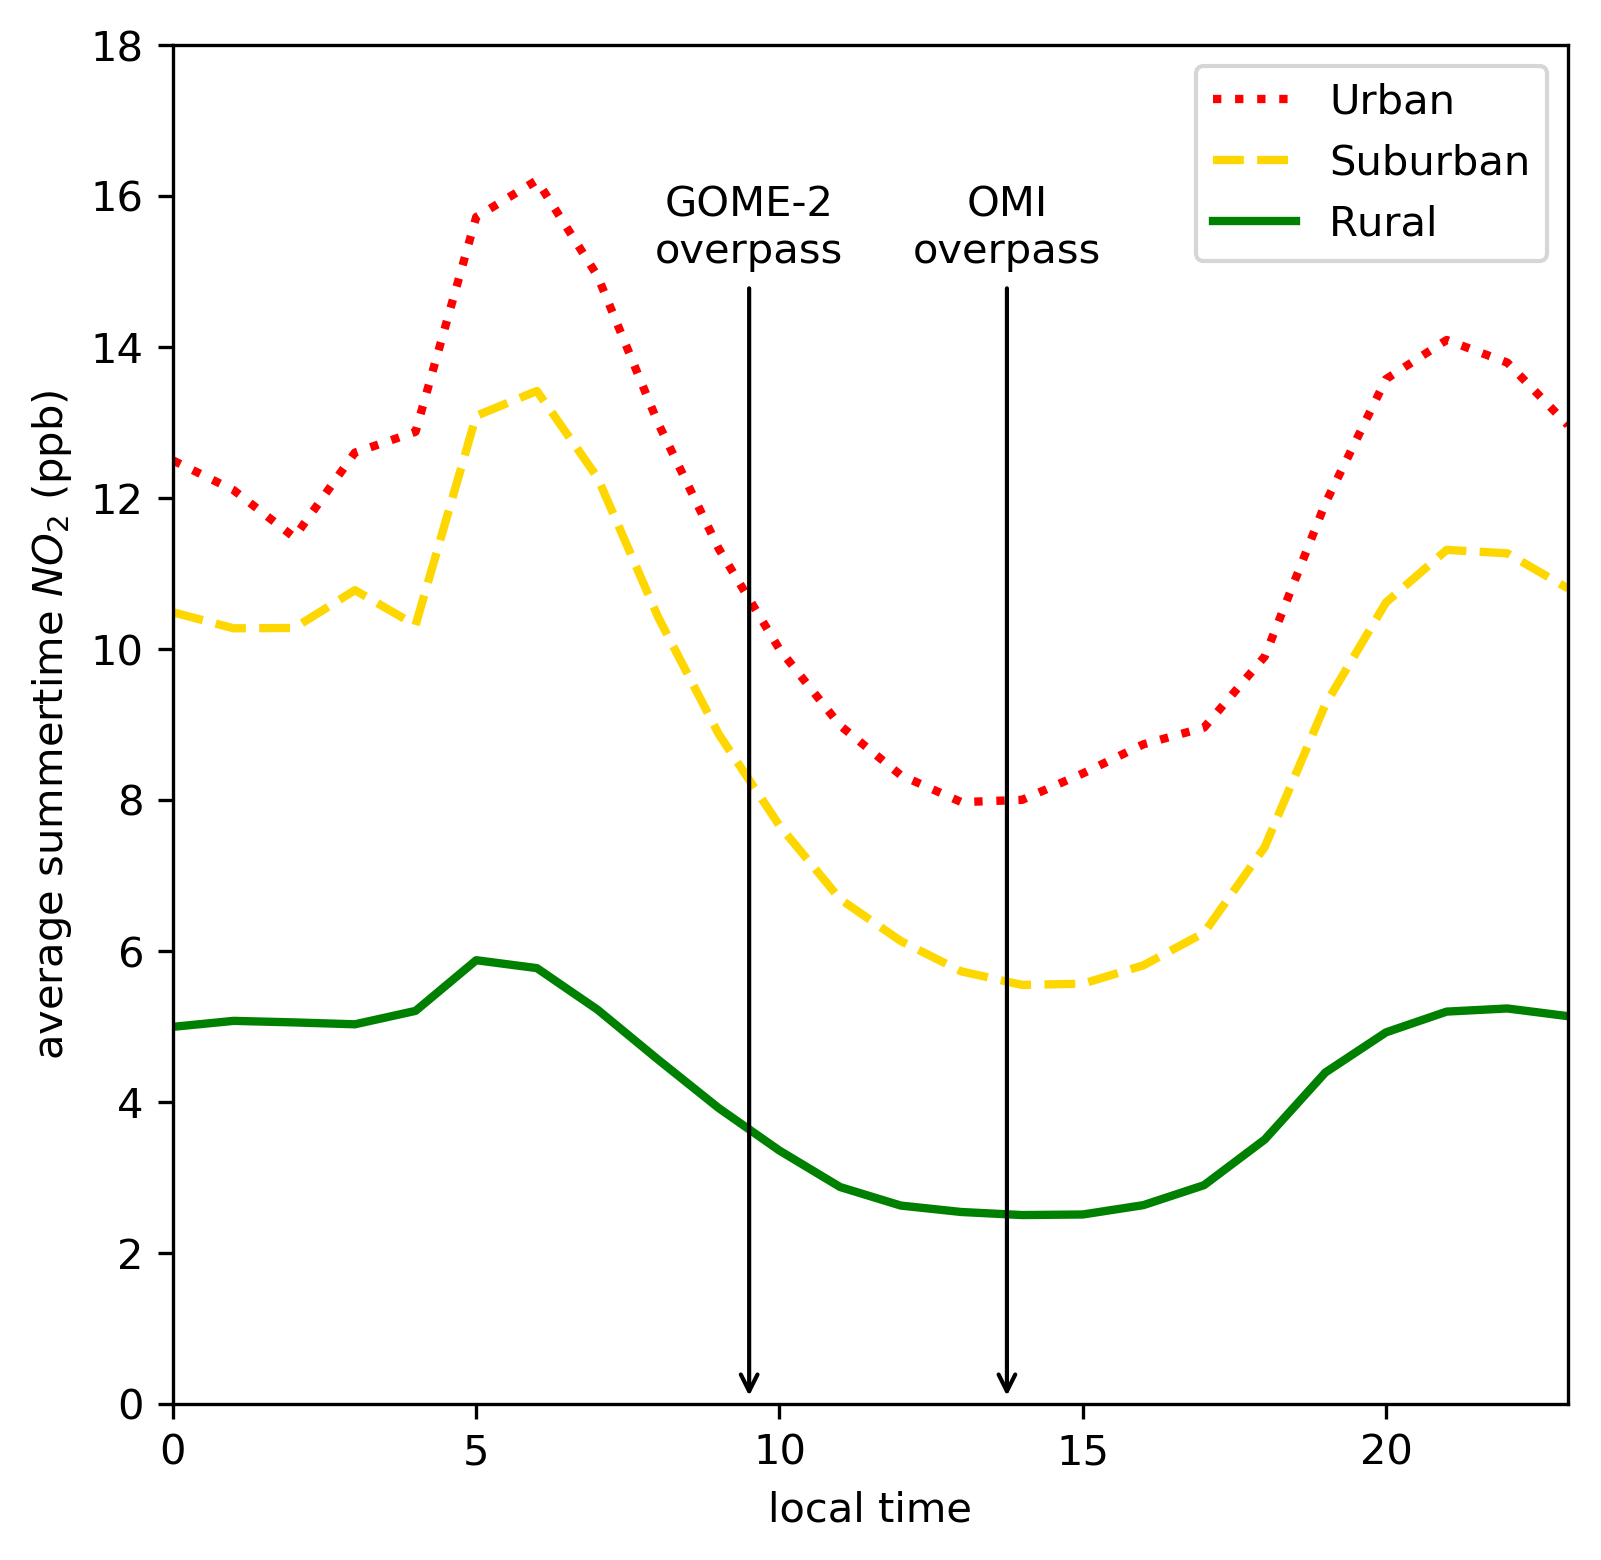

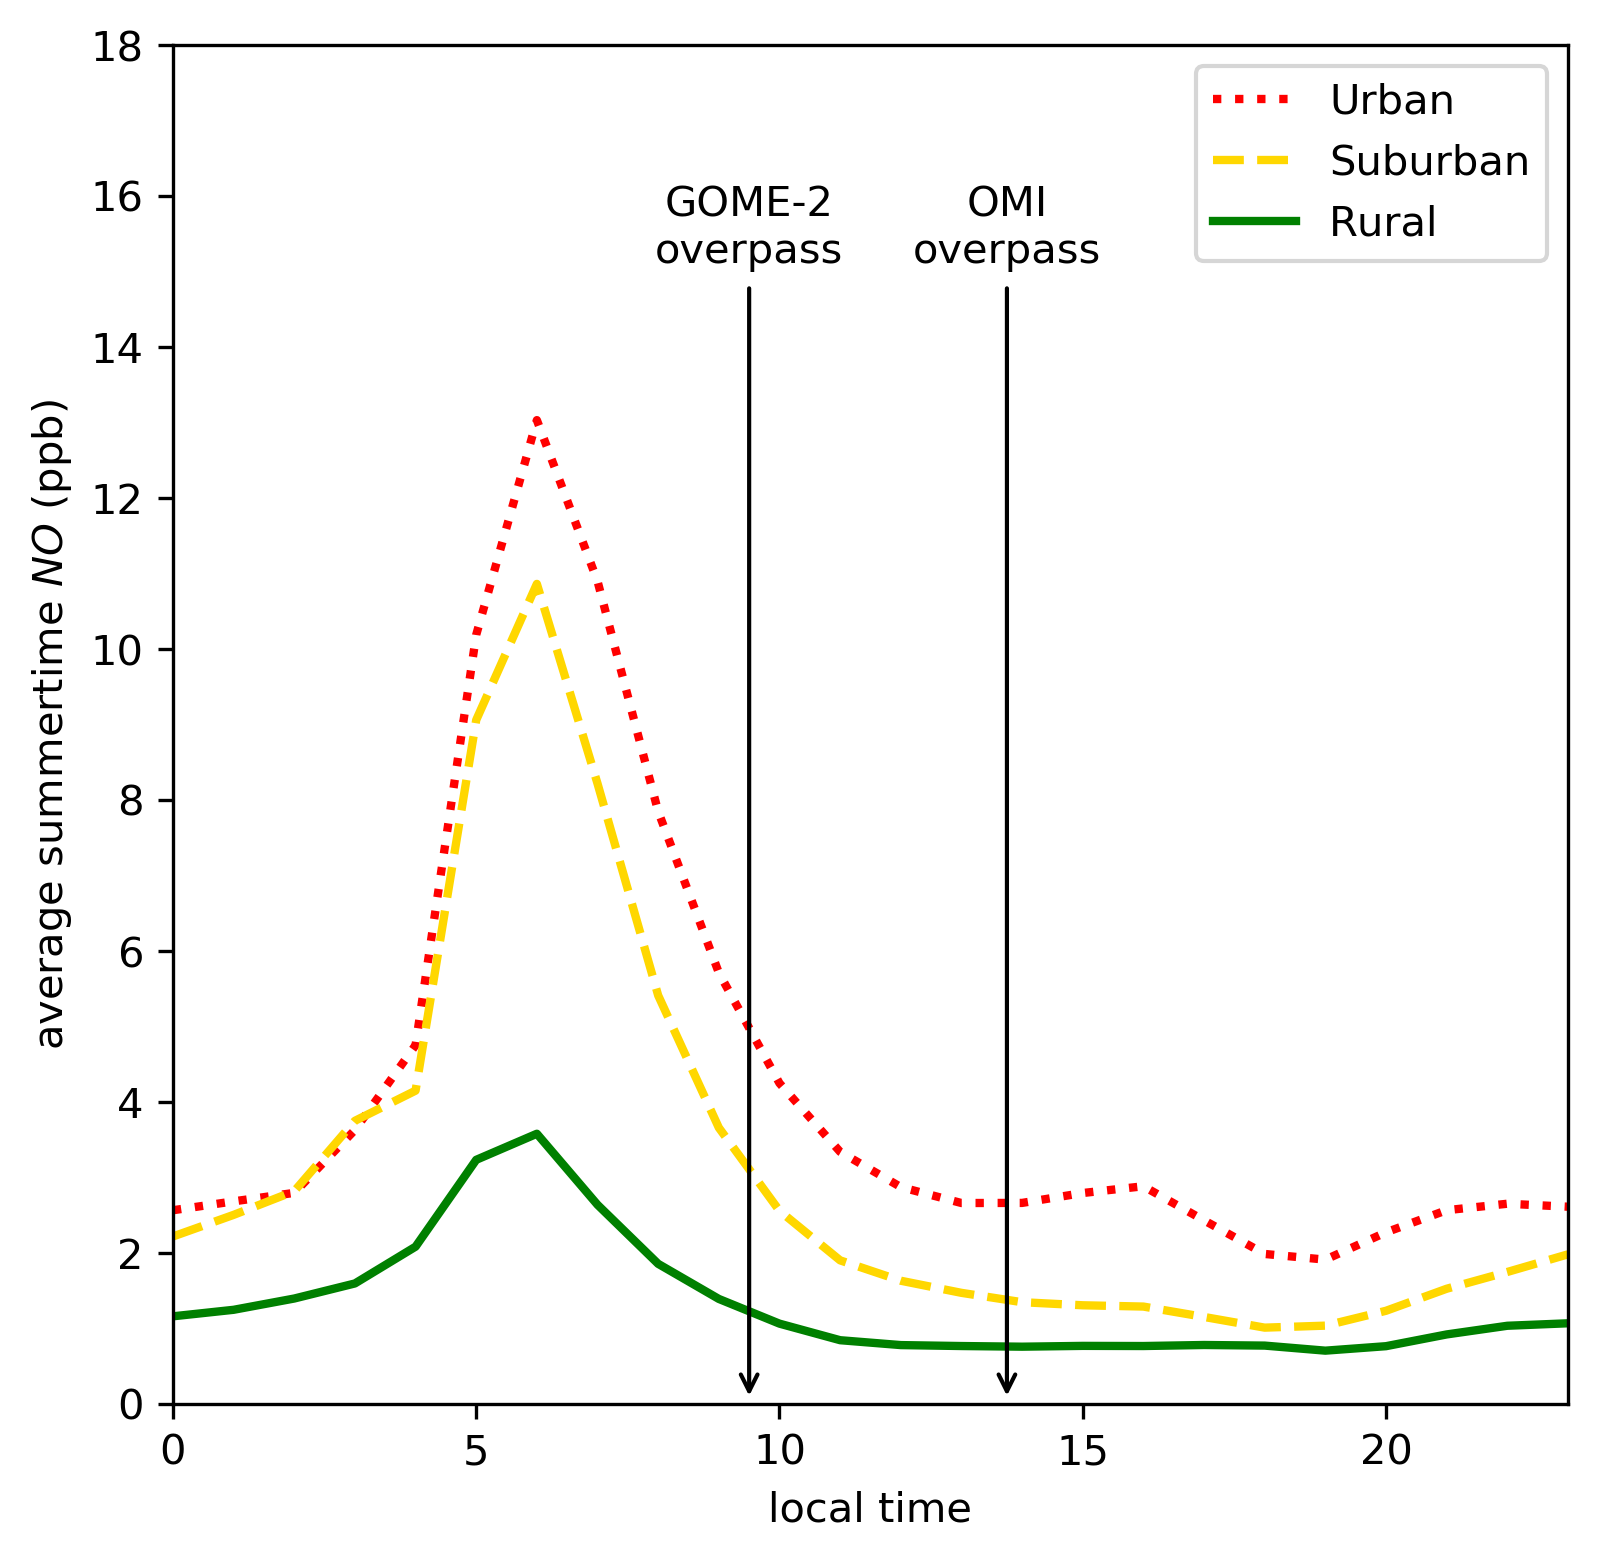

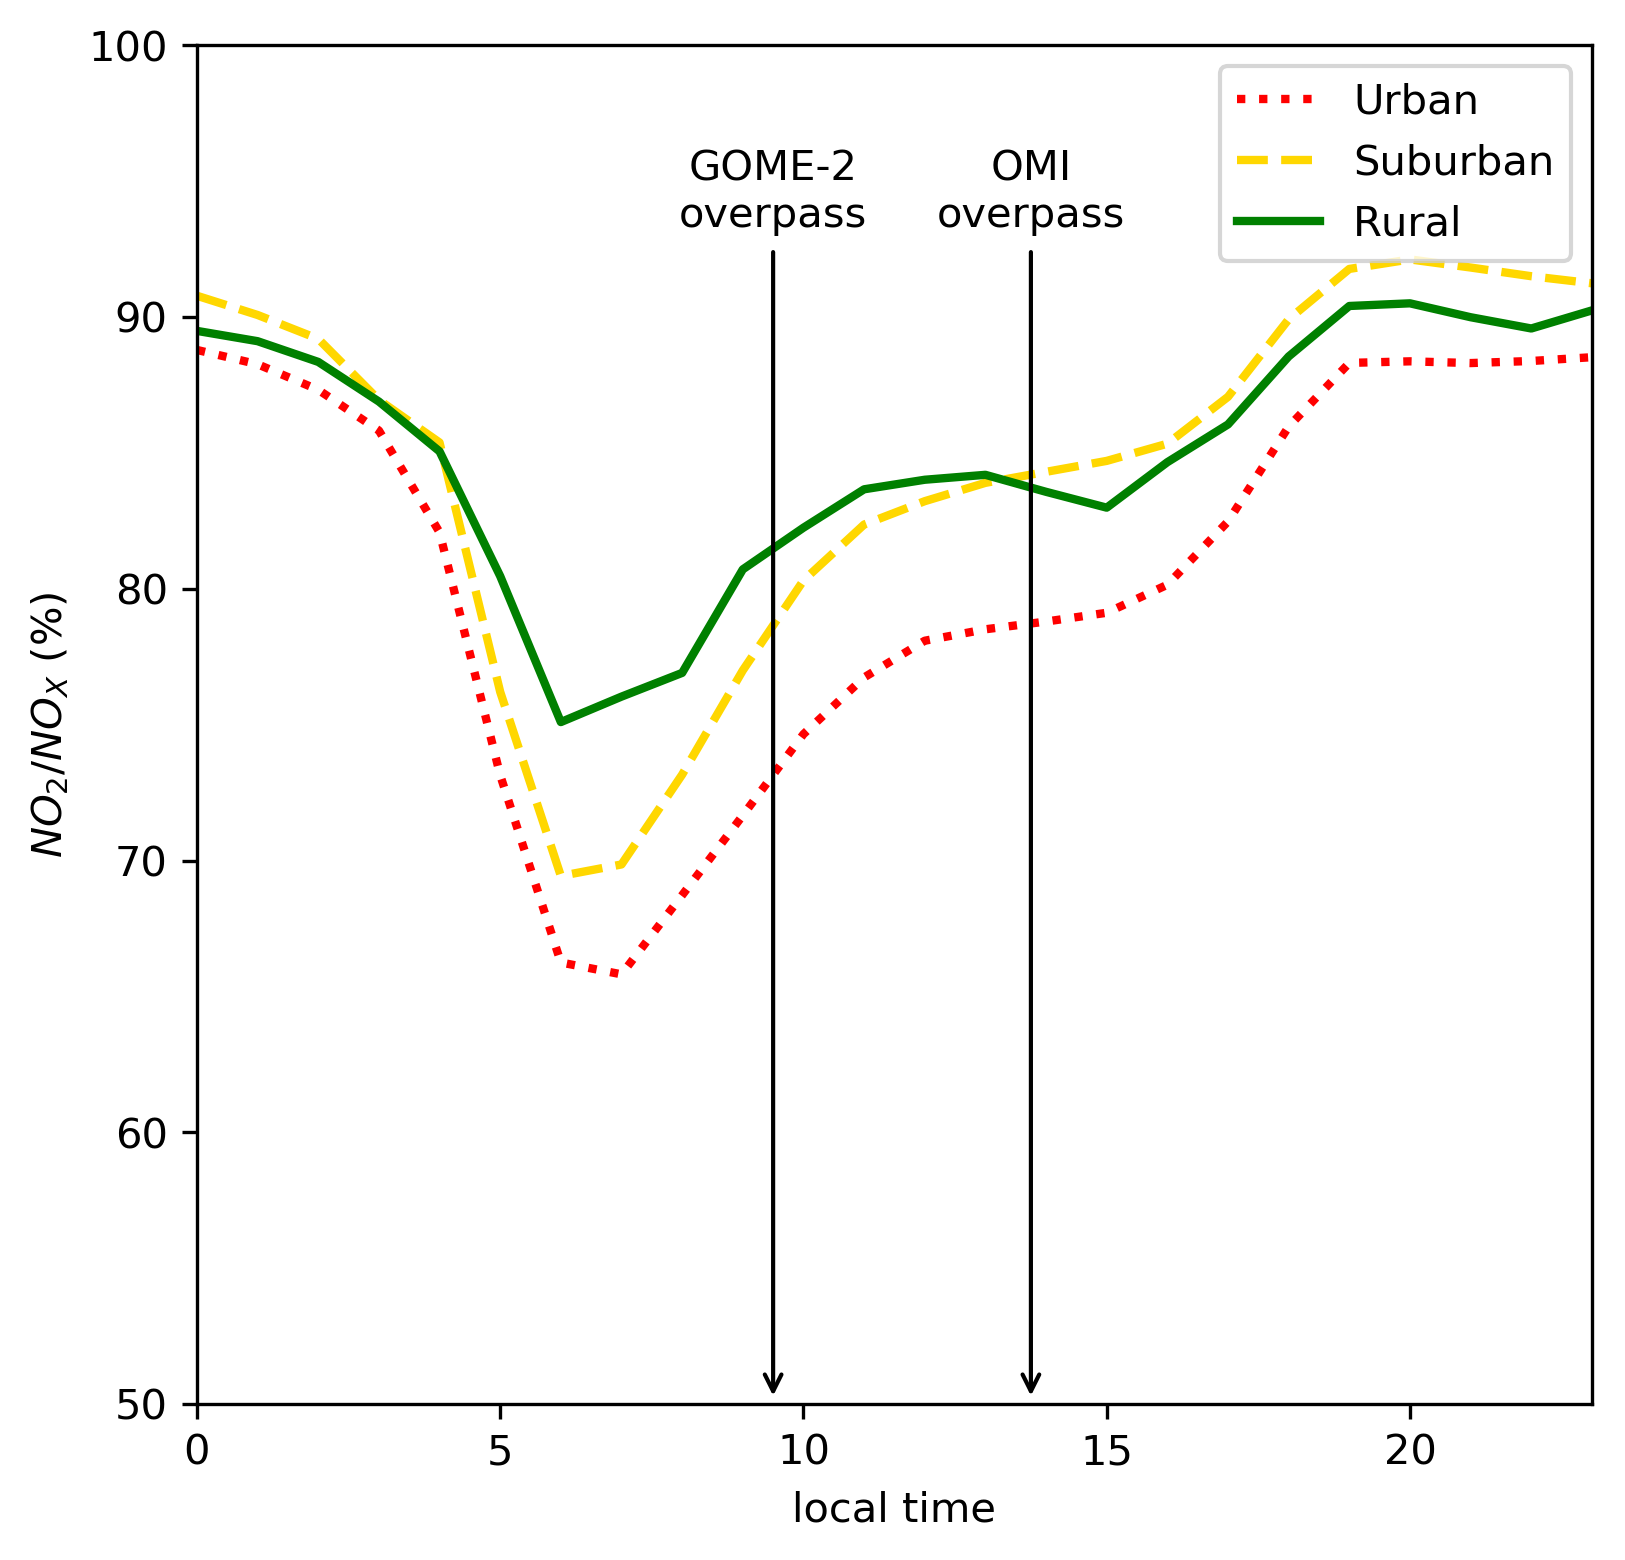

In [23]:
# plot it
hours = np.arange(0,24,1)
lw = 2

# no2
fig, ax = plt.subplots(figsize=(6,6),dpi=300)
plt.plot(hourly_no2.loc['URBAN AND CENTER CITY'], 'r:', linewidth=lw, label='Urban')
plt.plot(hourly_no2.loc['SUBURBAN'], '--', c='gold', linewidth=lw, label='Suburban')
plt.plot(hourly_no2.loc['RURAL'], 'g-', linewidth=lw, label='Rural')
plt.xlim(0,23)
plt.ylim(0,18)
plt.xlabel('local time')
plt.ylabel('average summertime $NO_2$ (ppb)')
plt.legend()
plt.annotate('GOME-2\noverpass', xy=(9.5, 0), xytext=(9.5,15),
            arrowprops=dict(color='k',arrowstyle='->'),
            horizontalalignment='center',
            verticalalignment='bottom',color='k'
            )
plt.annotate('OMI\noverpass', xy=(13.75, 0), xytext=(13.75,15),
            arrowprops=dict(color='k',arrowstyle='->'),
            horizontalalignment='center',
            verticalalignment='bottom', color='k'
            )
plt.show()

# no
fig, ax = plt.subplots(figsize=(6,6),dpi=300)
plt.plot(hourly_no.loc['URBAN AND CENTER CITY'], 'r:', linewidth=lw, label='Urban')
plt.plot(hourly_no.loc['SUBURBAN'], '--', c='gold', linewidth=lw, label='Suburban')
plt.plot(hourly_no.loc['RURAL'], 'g-', linewidth=lw, label='Rural')
plt.xlim(0,23)
plt.ylim(0,18)
plt.xlabel('local time')
plt.ylabel('average summertime $NO$ (ppb)')
plt.legend()
plt.annotate('GOME-2\noverpass', xy=(9.5, 0), xytext=(9.5,15),
            arrowprops=dict(color='k',arrowstyle='->'),
            horizontalalignment='center',
            verticalalignment='bottom',color='k'
            )
plt.annotate('OMI\noverpass', xy=(13.75, 0), xytext=(13.75,15),
            arrowprops=dict(color='k',arrowstyle='->'),
            horizontalalignment='center',
            verticalalignment='bottom', color='k'
            )
plt.show()


# no2/no
fig, ax = plt.subplots(figsize=(6,6),dpi=300)
plt.plot(hourly_nox_ratio.loc['URBAN AND CENTER CITY']*100., 'r:', linewidth=lw, label='Urban')
plt.plot(hourly_nox_ratio.loc['SUBURBAN']*100., '--', c='gold', linewidth=lw, label='Suburban')
plt.plot(hourly_nox_ratio.loc['RURAL']*100., 'g-', linewidth=lw, label='Rural')
plt.xlim(0,23)
plt.ylim(50.,100.)
plt.xlabel('local time')
plt.ylabel('$NO_2/NO_X$ (%)')
plt.legend(loc=1)
plt.annotate('GOME-2\noverpass', xy=(9.5, 50), xytext=(9.5,93),
            arrowprops=dict(color='k',arrowstyle='->'),
            horizontalalignment='center',
            verticalalignment='bottom',color='k'
            )
plt.annotate('OMI\noverpass', xy=(13.75, 50), xytext=(13.75,93),
            arrowprops=dict(color='k',arrowstyle='->'),
            horizontalalignment='center',
            verticalalignment='bottom', color='k'
            )
plt.show()

## Plot surface vs. satellite obs.

gome2


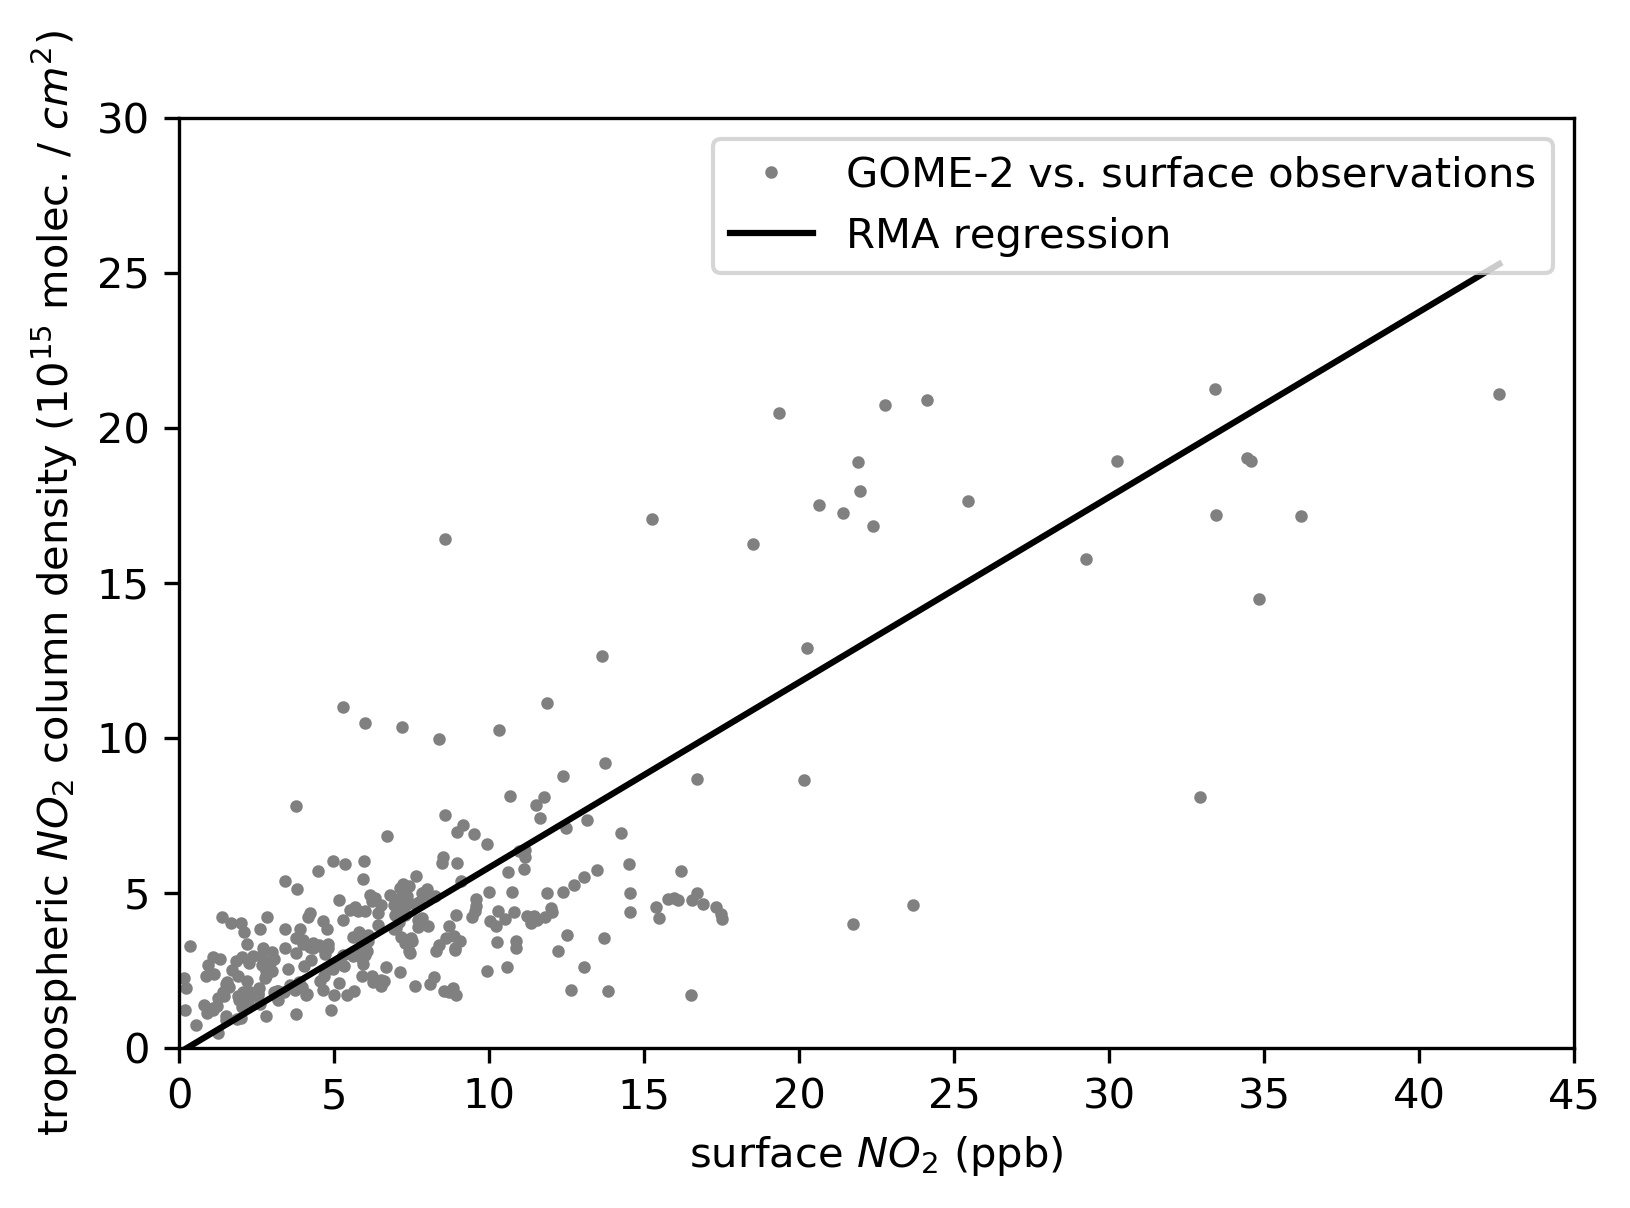

slope=0.597436675444
r2=0.613032290764
intercept=-0.147528930529
mean obs: 27.7133757962, median obs: 28.0, min obs 9.0.
omi


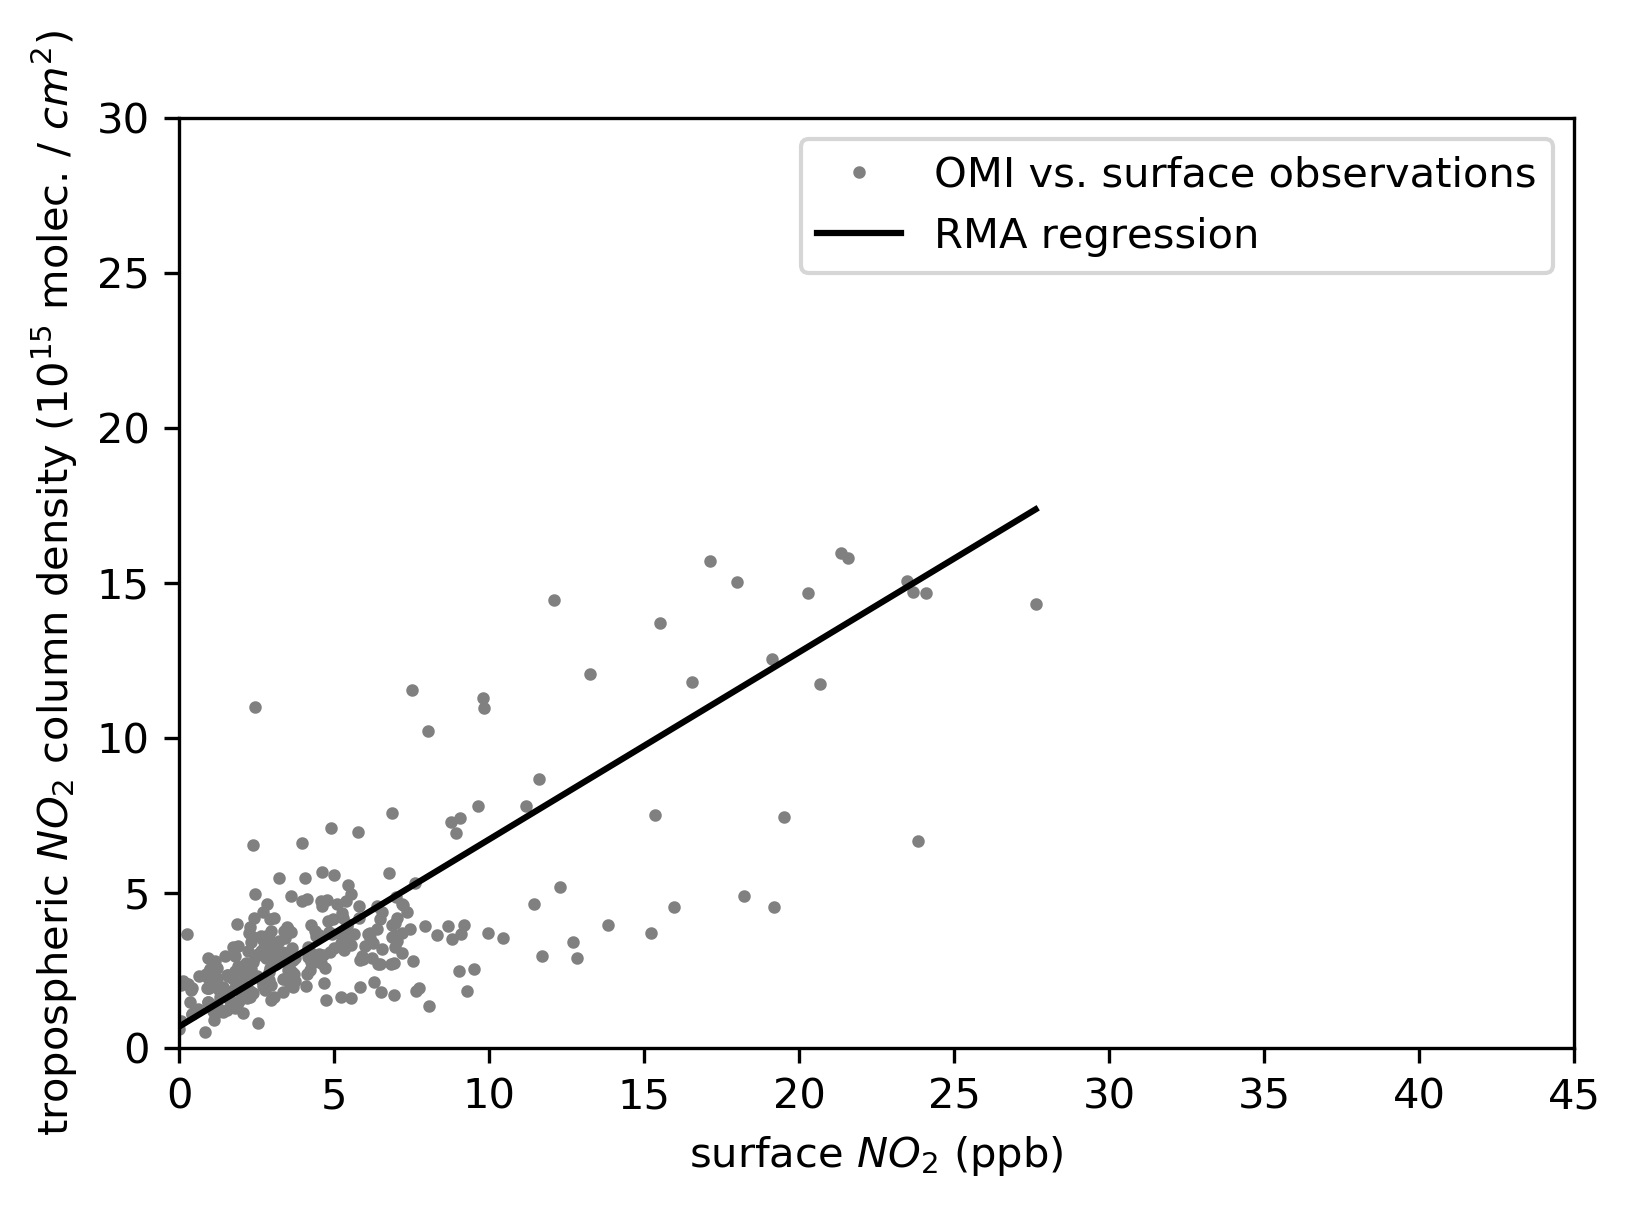

slope=0.603934419761
r2=0.594800784928
intercept=0.694499073766
mean obs: 27.7133757962, median obs: 28.0, min obs 9.0.


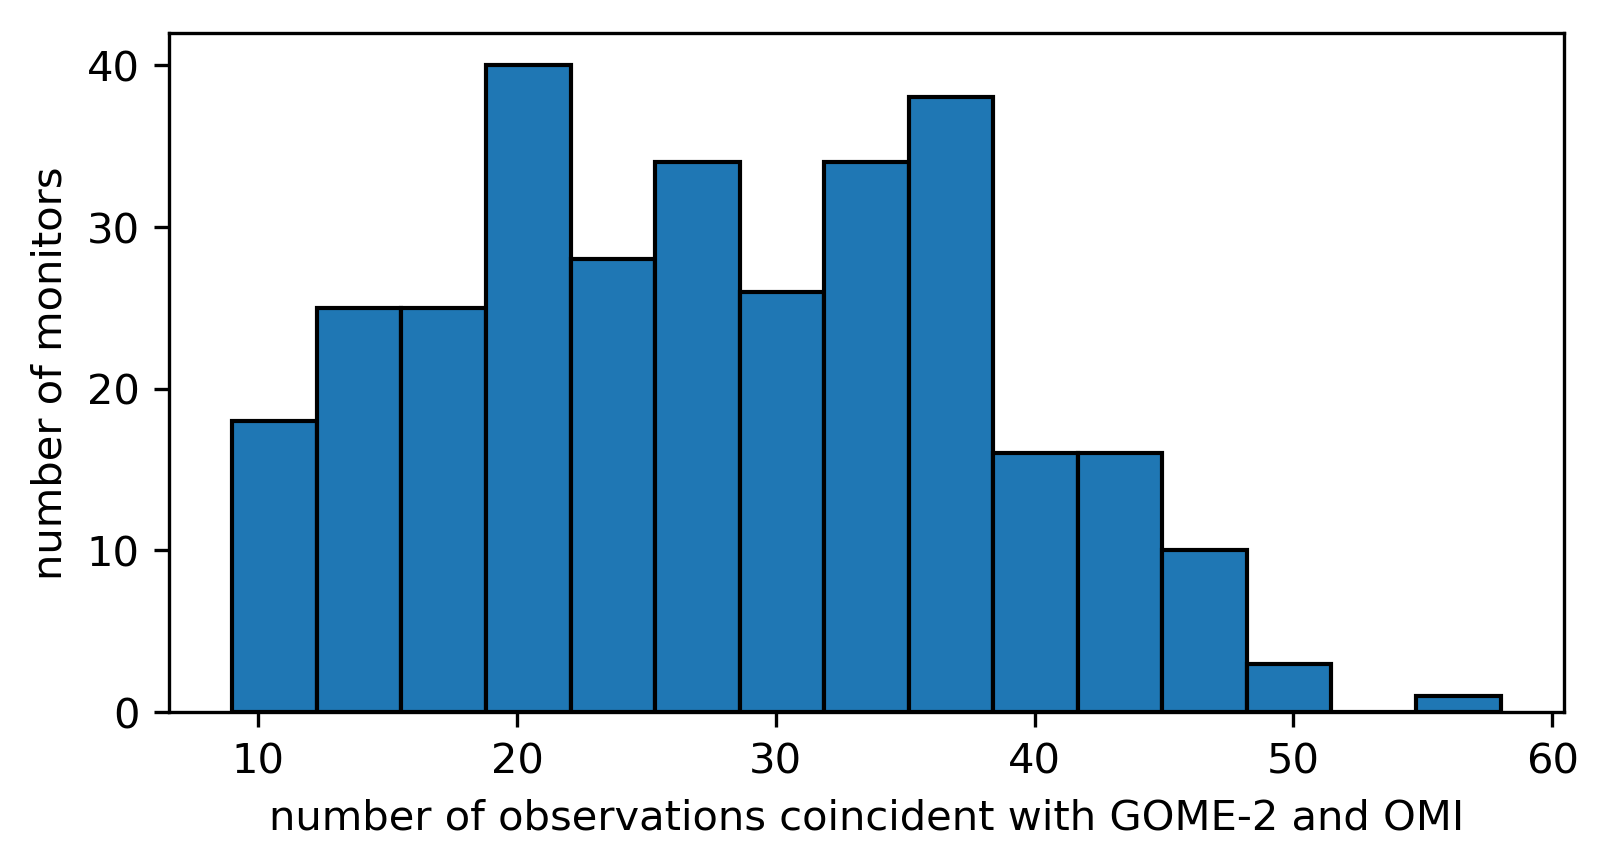

In [24]:
print('gome2')
go2SatAvg, go2AQSAvg, go2LatLon, go2N = compare_mean_dict(concDict,'go2Sat','go2AQS',mask_keys=['omiAQS','omiSat'])
slope, intercept, r_value, p_value, std_err = RMA(go2AQSAvg,go2SatAvg)
scatter_plot(go2AQSAvg, go2SatAvg, slope, intercept, xlabel='surface $NO_2$ (ppb)', \
             ylabel='tropospheric $NO_2$ column density ($10^{15}$ molec. / $cm^2$)',
             xlim=(0,45),ylim=(0,30), linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='GOME-2 vs. surface observations', linelabel='RMA regression')
go2_r2_value = np.round(r_value**2,3)
go2_slope = slope
print 'slope={}'.format(slope)
print 'r2={}'.format(r_value**2)
print 'intercept={}'.format(intercept)
print 'mean obs: {0}, median obs: {1}, min obs {2}.'.format(np.mean(go2N),np.median(go2N), np.min(go2N))

print('omi')
omiSatAvg, omiAQSAvg, omiLatLon, omiN = compare_mean_dict(concDict,'omiSat','omiAQS',mask_keys=['go2AQS','go2Sat'])
slope, intercept, r_value, p_value, std_err = RMA(omiAQSAvg,omiSatAvg)
scatter_plot(omiAQSAvg, omiSatAvg, slope, intercept, xlabel='surface $NO_2$ (ppb)', \
             ylabel='tropospheric $NO_2$ column density ($10^{15}$ molec. / $cm^2$)',
             xlim=(0,45),ylim=(0,30), linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='OMI vs. surface observations', linelabel='RMA regression')
             #markercolor = omiN)#,
             #title='All Monitors - $r^2$='+str(r2_value))
omi_r2_value = np.round(r_value**2,3)
omi_slope = slope
print 'slope={}'.format(slope)
print 'r2={}'.format(r_value**2)
print 'intercept={}'.format(intercept)
print 'mean obs: {0}, median obs: {1}, min obs {2}.'.format(np.mean(omiN),np.median(omiN), np.min(omiN))

# plot a histogram of the number of measurements made
plt.figure(figsize=(6,3), dpi=300)
plt.hist(omiN, edgecolor='k', bins=15)
plt.xlabel('number of observations coincident with GOME-2 and OMI')
plt.ylabel('number of monitors')
plt.show()

In [25]:
def compare_diff(yourDict, go2AQSKey, go2SatKey, omiAQSKey, omiSatKey):
    diffAQS = np.array([])
    diffSat = np.array([])
    latlon = np.array([])
    for coordTup, var in yourDict.iteritems():
        go2AQS = var[go2AQSKey]
        go2Sat = var[go2SatKey]
        omiAQS = var[omiAQSKey]
        omiSat = var[omiSatKey]
        monID = var['ID']
        if np.all(np.isnan(go2AQS) | np.isnan(go2Sat)) or \
            np.all(np.isnan(omiAQS) | np.isnan(omiSat)):
            continue # don't append monitor if it's empty
#         # Southern California
#         if  monID>10.**9. or \
#              np.all([soCalMon!=str(monID)[:4] for soCalMon in soCal]):
#             continue
        mask = ~np.isnan(go2AQS) & ~np.isnan(go2Sat) & ~np.isnan(omiAQS) & ~np.isnan(omiSat)
        diffAQS = np.append(diffAQS,np.mean(go2AQS[mask]-omiAQS[mask]))
        diffSat = np.append(diffSat,np.mean(go2Sat[mask]-omiSat[mask]))
        latlon = np.append(latlon,coordTup)
    return diffAQS, diffSat, latlon

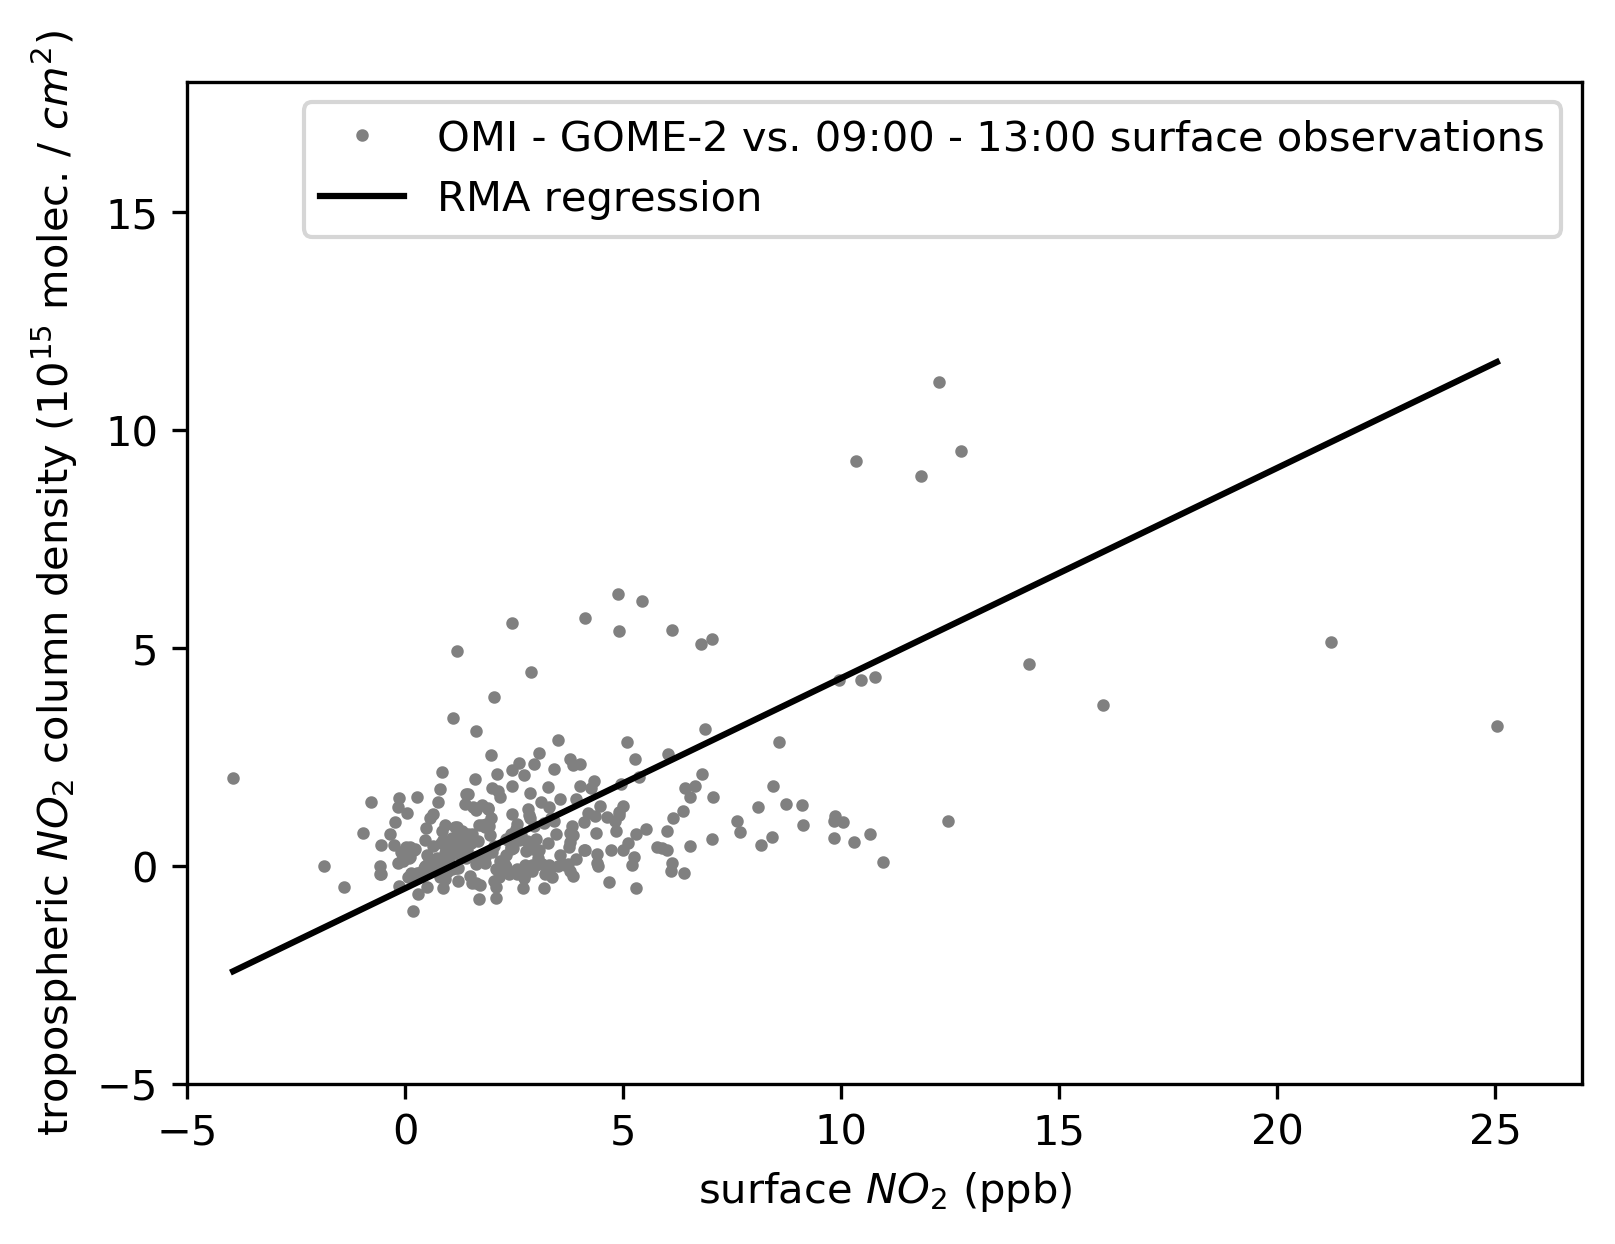

0.48208883001290803
0.24518411804854445
(314,)


In [26]:
aqsDiff, satDiff, diffLatLon = compare_diff(concDict, 'go2AQS', 'go2Sat', 'omiAQS', 'omiSat')
slope, intercept, r_value, p_value, std_err = RMA(aqsDiff,satDiff)
scatter_plot(aqsDiff, satDiff, slope, intercept, xlabel='surface $NO_2$ (ppb)', \
             ylabel='tropospheric $NO_2$ column density ($10^{15}$ molec. / $cm^2$)',
             linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='OMI - GOME-2 vs. 09:00 - 13:00 surface observations', linelabel='RMA regression', 
             xlim=(-5,27), ylim=(-5,18))#,\
            #title='All Monitors - $r^2$='+str(r2_value))
diff_r2_value = np.round(r_value**2,3)
diff_slope = slope
print slope
print r_value**2
print aqsDiff.shape

# Look at urban sites...

In [27]:
# reduce full attributes to just the 341 monitors that could be in our dataset
full_atts_aqs = full_atts.set_index('loc_id').loc[atts['loc_id']].drop_duplicates()

In [28]:
# get satellite grid row,col for each monitor
# # initialize row,col in full_atts_aqs
# full_atts_aqs['row'] = np.full(full_atts_aqs.shape[0],np.nan)
# full_atts_aqs['col'] = np.full(full_atts_aqs.shape[0],np.nan)

# initialize arrays because we can't modify a df we're looping over
ind = []
row = [] # x/column/longitude
col = [] # y/row/latitude
for i,data in full_atts_aqs.iterrows():
    ind.append(i) # index array - to make sure order is OK
    lat = np.float64(data['Latitude'])
    lon = np.float64(data['Longitude'])
    (row_i,col_i) = getind_latlon(lat,lon,lat2d,lon2d)
    row.append(row_i) # column array
    col.append(col_i) # row array
full_atts_aqs.loc[ind,'row'] = row
full_atts_aqs.loc[ind,'col'] = col

In [29]:
omiSatVCD = read_in_sat('OMI',day.strftime('%m-%d-%Y'))
go2SatVCD = read_in_sat('GOME2',day.strftime('%m-%d-%Y'))

In [30]:
# recalculate everything in pandas (SO EASY!!!)
aqs = morning.drop('start_time',axis=1)
aqs = aqs.rename(columns={'Sample Value':'morning'})
aqs['afternoon'] = afternoon['Sample Value']
aqs['diff'] = aqs['morning'] - aqs['afternoon']
aqs['ratio'] = aqs['morning'] / aqs['afternoon']
# remove divide by 0s and negative values 
#   (I leave negative values elsewhere so as not to bias results)
aqs['ratio'].loc[~np.isfinite(aqs['ratio'])|
                 (aqs['morning']<0)|(aqs['afternoon']<0)] = np.nan 
aqs['date'] = aqs['date'].astype(np.datetime64) # convert to datetime format
aqs = aqs.join(full_atts_aqs,on='loc_id',rsuffix='_att')

# read in satellite observations and add them to the aqs df
# initialize columns to hold satellite observations
aqs['gome2'] = np.full(aqs.shape[0],np.nan)
aqs['omi'] = np.full(aqs.shape[0],np.nan)
# loop over daily satellite files
for day in timesList:
    omiSatVCD = read_in_sat('OMI',day.strftime('%m-%d-%Y'))
    go2SatVCD = read_in_sat('GOME2',day.strftime('%m-%d-%Y'))
    # assign np.nan to fillValues
    omiSatVCD = np.where(omiSatVCD==omiSatVCD._FillValue, 
                         np.nan, omiSatVCD)/10.**15. # fix units
    go2SatVCD = np.where(go2SatVCD==go2SatVCD._FillValue, 
                         np.nan, go2SatVCD)
    # get aqs values for this day
    aqs_today = aqs.loc[aqs['date']==np.datetime64(day)]
    
    # get the lat/lon for each aqs measurement on this day
    ind_today  = []
    omi_today = []
    go2_today = []
    for i,data in aqs_today.iterrows():
        # read in satellite data
        omiSatVCD = read_in_sat('OMI',day.strftime('%m-%d-%Y'))
        go2SatVCD = read_in_sat('GOME2',day.strftime('%m-%d-%Y'))
        # assign np.nan to fillValues
        omiSatVCD = np.where(omiSatVCD==omiSatVCD._FillValue, 
                             np.nan, omiSatVCD)/10.**15. # fix units
        go2SatVCD = np.where(go2SatVCD==go2SatVCD._FillValue, 
                             np.nan, go2SatVCD)
        ind_today.append(i)
        omi_today.append(omiSatVCD[data['row']][data['col']])
        go2_today.append(go2SatVCD[data['row']][data['col']])
        
    aqs['gome2'].loc[ind_today] = go2_today
    aqs['omi'].loc[ind_today]   = omi_today
    
aqs['sat_diff']  = aqs['gome2'] - aqs['omi']
aqs['sat_ratio'] = aqs['gome2'] / aqs['omi']
# remove divide by 0s and negative values 
#   (I leave negative values elsewhere so as not to bias results)
aqs['sat_ratio'].loc[~np.isfinite(aqs['sat_ratio'])|
                     (aqs['gome2']<0)|(aqs['omi']<0)] = np.nan

# do a groupby mean to get spatial correlation at each site
aqs_avg = aqs.groupby('loc_id').mean()
cols_with_strings = full_atts_aqs.columns.difference(aqs_avg)
aqs_avg = aqs_avg.join(full_atts_aqs[cols_with_strings],on='loc_id',rsuffix='_att') # add back some things that got deleted

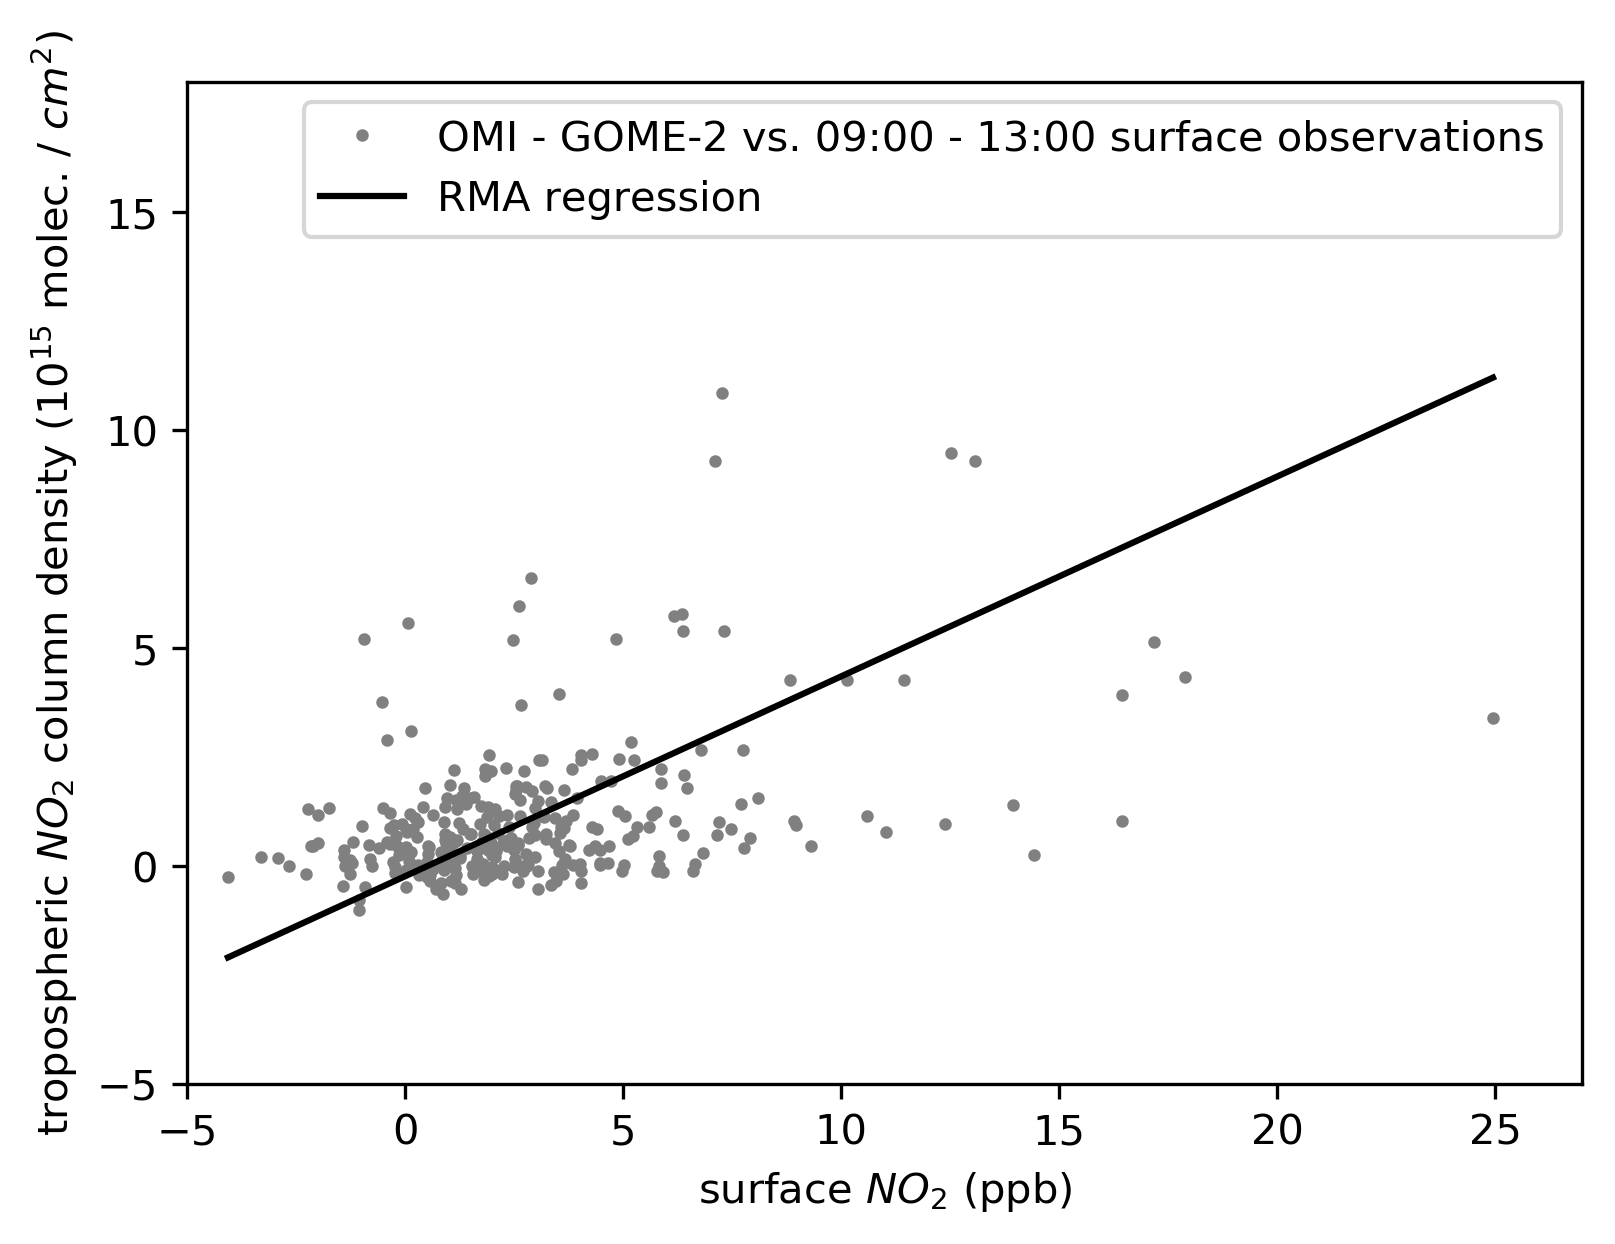

0.45835195676274115
0.17609806027672847
(314,)


In [31]:
# plot diff r^2 using groupby just to check....
slope, intercept, r_value, p_value, std_err = RMA(aqs_avg['diff'],aqs_avg['sat_diff'])
scatter_plot(aqs_avg['diff'], aqs_avg['sat_diff'], slope, intercept, xlabel='surface $NO_2$ (ppb)', \
             ylabel='tropospheric $NO_2$ column density ($10^{15}$ molec. / $cm^2$)',
             linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='OMI - GOME-2 vs. 09:00 - 13:00 surface observations', linelabel='RMA regression', 
             xlim=(-5,27), ylim=(-5,18))#,\
            #title='All Monitors - $r^2$='+str(r2_value))
diff_r2_value = np.round(r_value**2,3)
diff_slope = slope
print slope
print r_value**2
print aqsDiff.shape

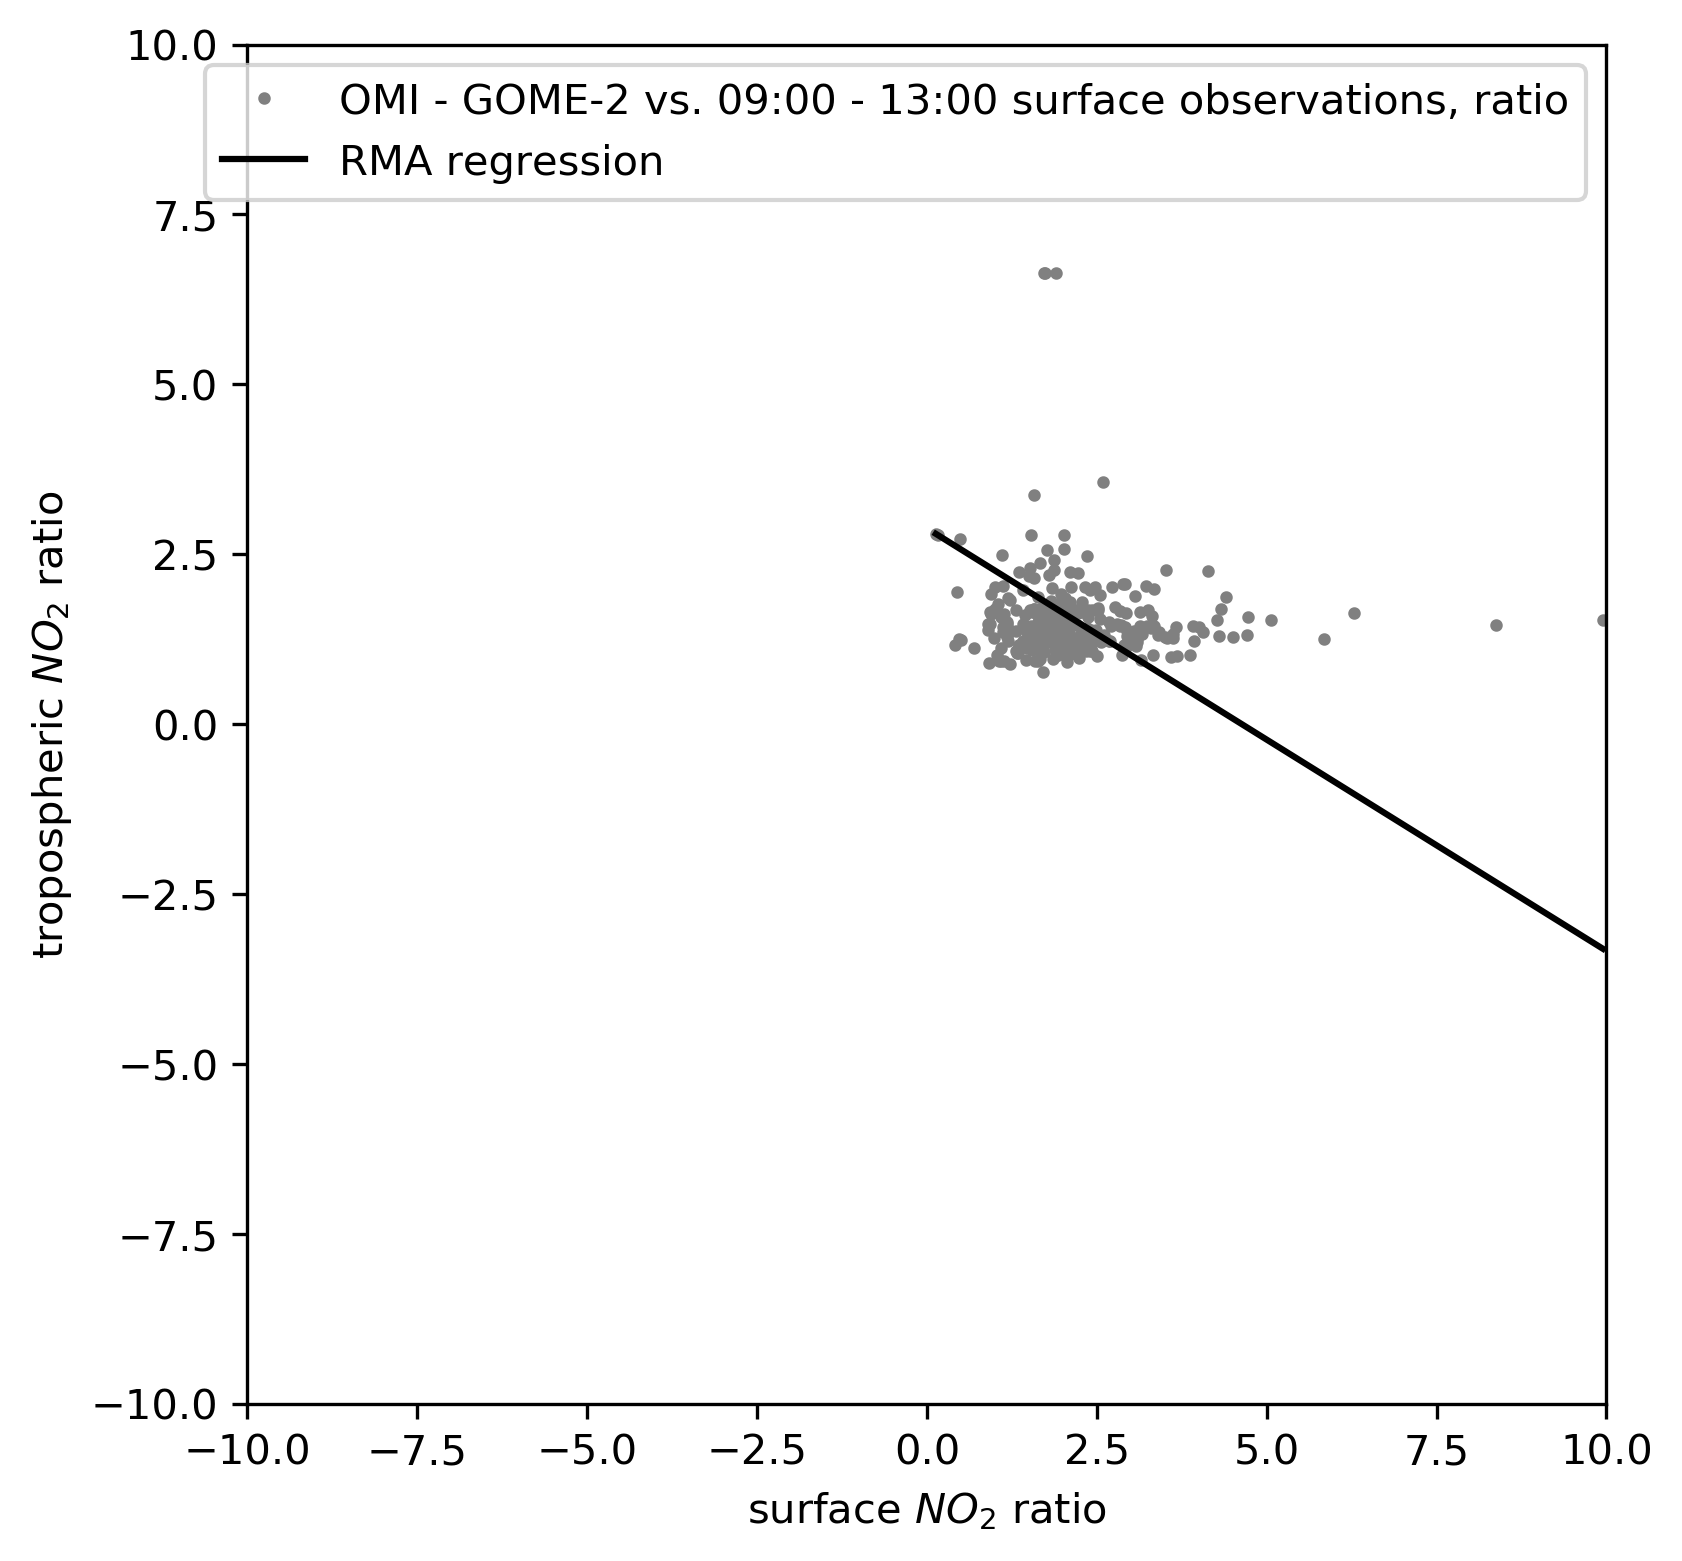

-0.6220622023365344
0.0039025727205177878
(314,)


In [32]:
# plot ratio r^2
slope, intercept, r_value, p_value, std_err = RMA(aqs_avg['ratio'], aqs_avg['sat_ratio'])
scatter_plot(aqs_avg['ratio'], aqs_avg['sat_ratio'], slope, intercept, xlabel='surface $NO_2$ ratio', \
             ylabel='tropospheric $NO_2$ ratio',
             linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='OMI - GOME-2 vs. 09:00 - 13:00 surface observations, ratio', linelabel='RMA regression', 
             xlim=(-10,10), ylim=(-10,10))#,\
            #title='All Monitors - $r^2$='+str(r2_value))
diff_r2_value = np.round(r_value**2,3)
diff_slope = slope
print slope
print r_value**2
print aqsDiff.shape

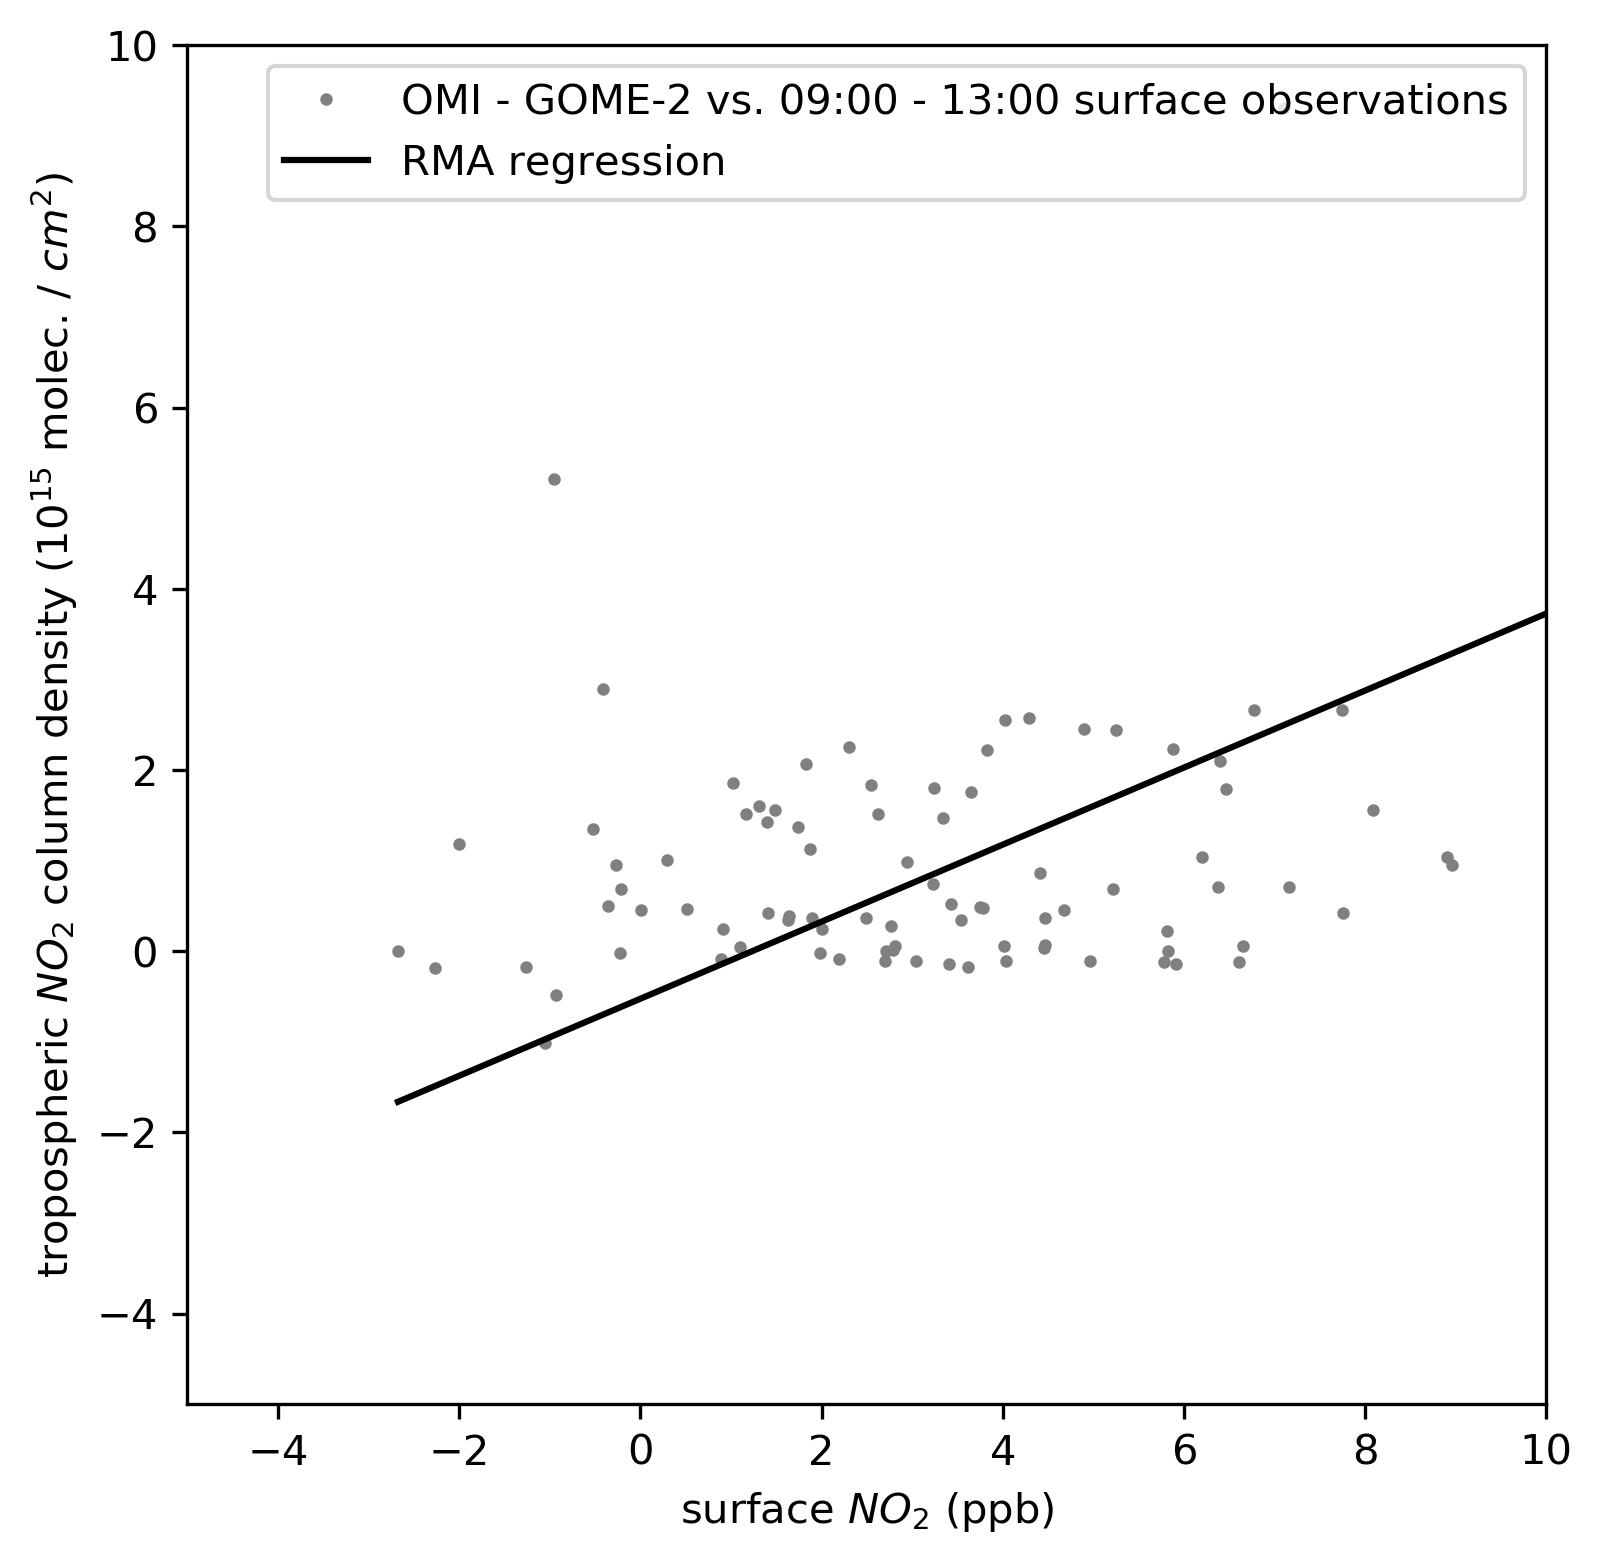

0.4252332504432458
0.15184995782006128
(94,)


In [33]:
# select only urban monitors and plot sat diff r^2
aqsDiff = aqs_avg['diff'].loc[aqs_avg['Location Setting']=='URBAN AND CENTER CITY']
satDiff = aqs_avg['sat_diff'].loc[aqs_avg['Location Setting']=='URBAN AND CENTER CITY']
slope, intercept, r_value, p_value, std_err = RMA(aqsDiff,satDiff)
scatter_plot(aqsDiff, satDiff, slope, intercept, xlabel='surface $NO_2$ (ppb)', \
             ylabel='tropospheric $NO_2$ column density ($10^{15}$ molec. / $cm^2$)',
             linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='OMI - GOME-2 vs. 09:00 - 13:00 surface observations', linelabel='RMA regression', 
             xlim=(-5,10), ylim=(-5,10))#,\
            #title='All Monitors - $r^2$='+str(r2_value))
diff_r2_value = np.round(r_value**2,3)
diff_slope = slope
print slope
print r_value**2
print aqsDiff.shape

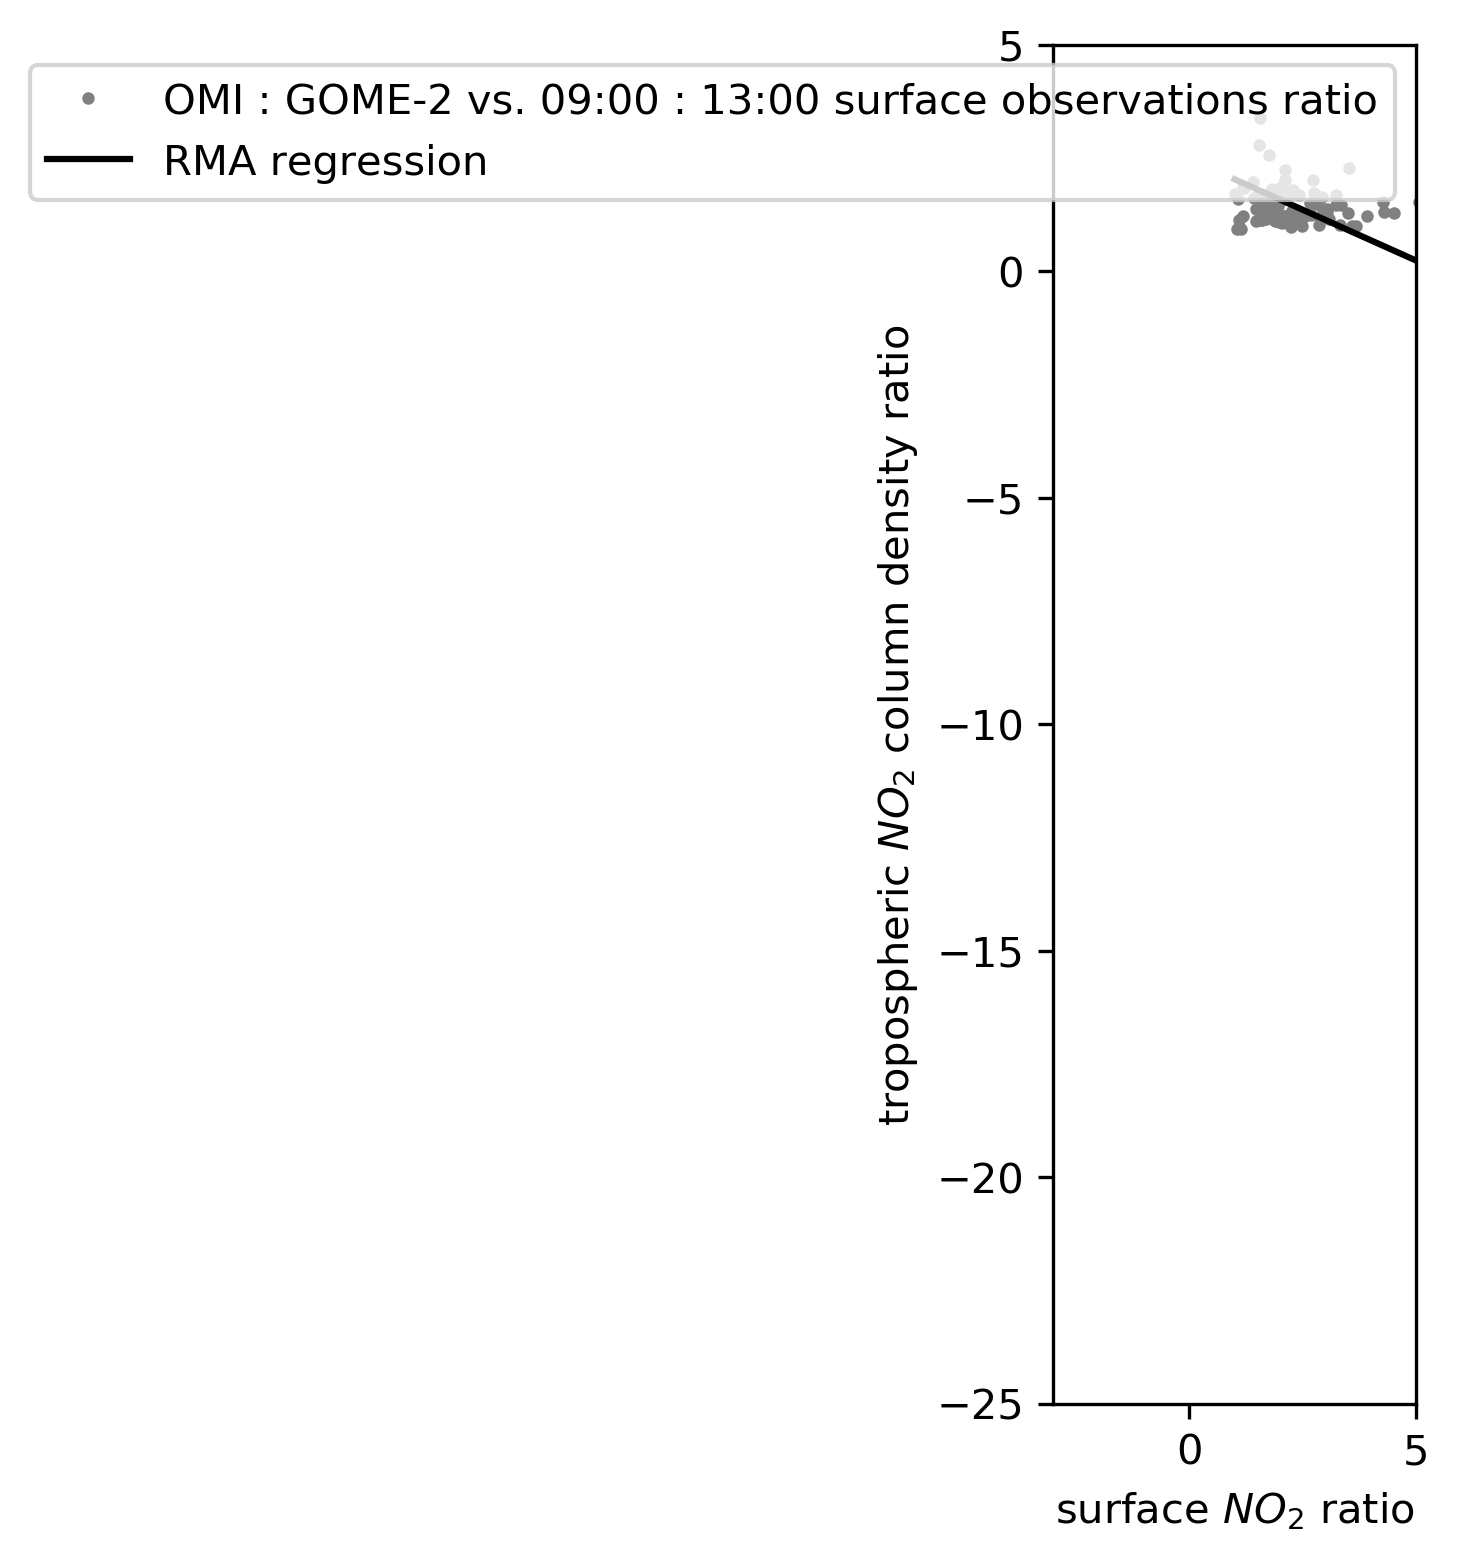

-0.4479888070716454
0.02245675151150996
(94,)


In [34]:
# select only urban monitors and plot sat ratio r^2
aqsDiff = aqs_avg['ratio'].loc[aqs_avg['Location Setting']=='URBAN AND CENTER CITY']
satDiff = aqs_avg['sat_ratio'].loc[aqs_avg['Location Setting']=='URBAN AND CENTER CITY']
slope, intercept, r_value, p_value, std_err = RMA(aqsDiff,satDiff)
scatter_plot(aqsDiff, satDiff, slope, intercept, xlabel='surface $NO_2$ ratio', \
             ylabel='tropospheric $NO_2$ column density ratio',
             linestyle='-', linecolor='k', marker='.', markercolor='gray',
             scatterlabel='OMI : GOME-2 vs. 09:00 : 13:00 surface observations ratio', linelabel='RMA regression', 
             xlim=(-3,5), ylim=(-25,5))#,\
            #title='All Monitors - $r^2$='+str(r2_value))
diff_r2_value = np.round(r_value**2,3)
diff_slope = slope
print slope
print r_value**2
print aqsDiff.shape

In [35]:
print(omiRange)
print(go2Range)
print('omi slope = {}'.format(omi_slope))
print('omi r2 = {}'.format(omi_r2_value))
print('gome2 slope = {}'.format(go2_slope))
print('gome2 r2 = {}'.format(go2_r2_value))
print('diff slope = {}'.format(diff_slope))
print('diff r2 = {}'.format(diff_r2_value))
print(aqsDiff.shape)

(13, 13)
(9, 9)
omi slope = 0.603934419761
omi r2 = 0.595
gome2 slope = 0.597436675444
gome2 r2 = 0.613
diff slope = -0.447988807072
diff r2 = 0.022
(94,)


# Plot Individual Cities

In [36]:
def bar_plot(aqs_city_avg,cities='all',figsize=(6,4),rotation=90,
             labels='same_as_index',ylim=(0,4),greenlabel='AQS 09:00/13:00 ratio'):
    # plot just the top 6 cities
    if cities == 'all':
        aqs_city_subset = aqs_city_avg
    else:
        aqs_city_subset = aqs_city_avg.loc[cities]
    fig, ax = plt.subplots(figsize=figsize,dpi=300)

    ind = np.arange(aqs_city_subset.shape[0])    # the x locations for the groups
    width = 0.3
    p1 = ax.bar(ind,aqs_city_subset['ratio'],width,
                label=greenlabel,color='olivedrab')
    p2 = ax.bar(ind+width,aqs_city_subset['sat_ratio'],width,
                label='GOME2/OMI column ratio',color='lightblue',hatch='//')
    plt.legend()

    #ax.set_title('ratio at surface and in column')
    ax.set_xticks(ind + width / 2)
    if labels == 'same_as_index':
        ax.set_xticklabels(aqs_city_subset.index,rotation=rotation)
    else:
        ax.set_xticklabels(labels,rotation=rotation)

    plt.ylabel('ratio')
    plt.ylim(ylim)
    plt.axhline(1.,color='k',linestyle='--')

In [37]:
# top 6 most populous cities
# 1. New York
# 2. LA
# 3. Chicago
# 4. Houston
# 5. Phoenix
# 6. Philadelphia

In [38]:
# Time of morning (00:00-11:00) NO2 concentration peak -
# Minimum over entire day

In [39]:
top6_cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia']

# get the averages for each city
# ... and drop lancaster that's really an anomaly
aqs_city_avg = aqs_avg.groupby(['row','col','City Name']).mean().groupby('City Name').mean()
aqs_cbsa_avg = aqs_avg.groupby(['row','col','CBSA Name']).mean().groupby('CBSA Name').mean()

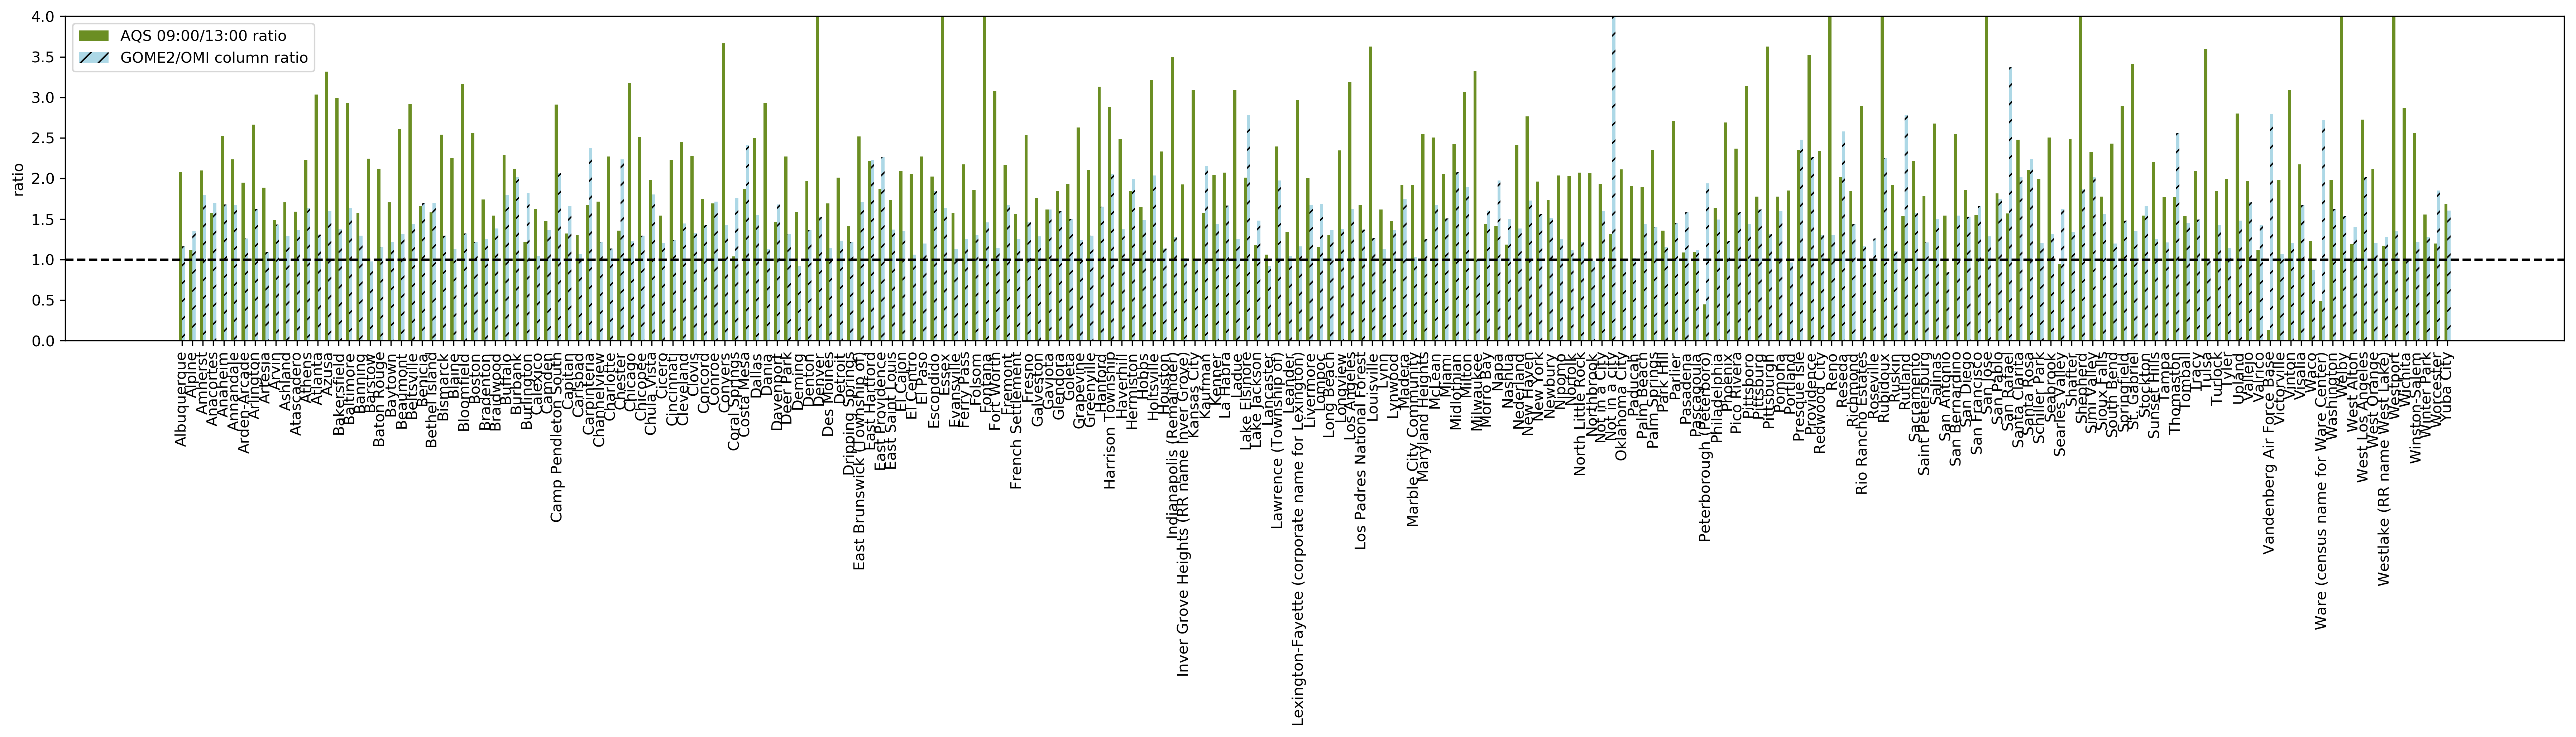

In [40]:
# plot all the cities just to show that we can
bar_plot(aqs_city_avg,cities='all',figsize=(30,4))

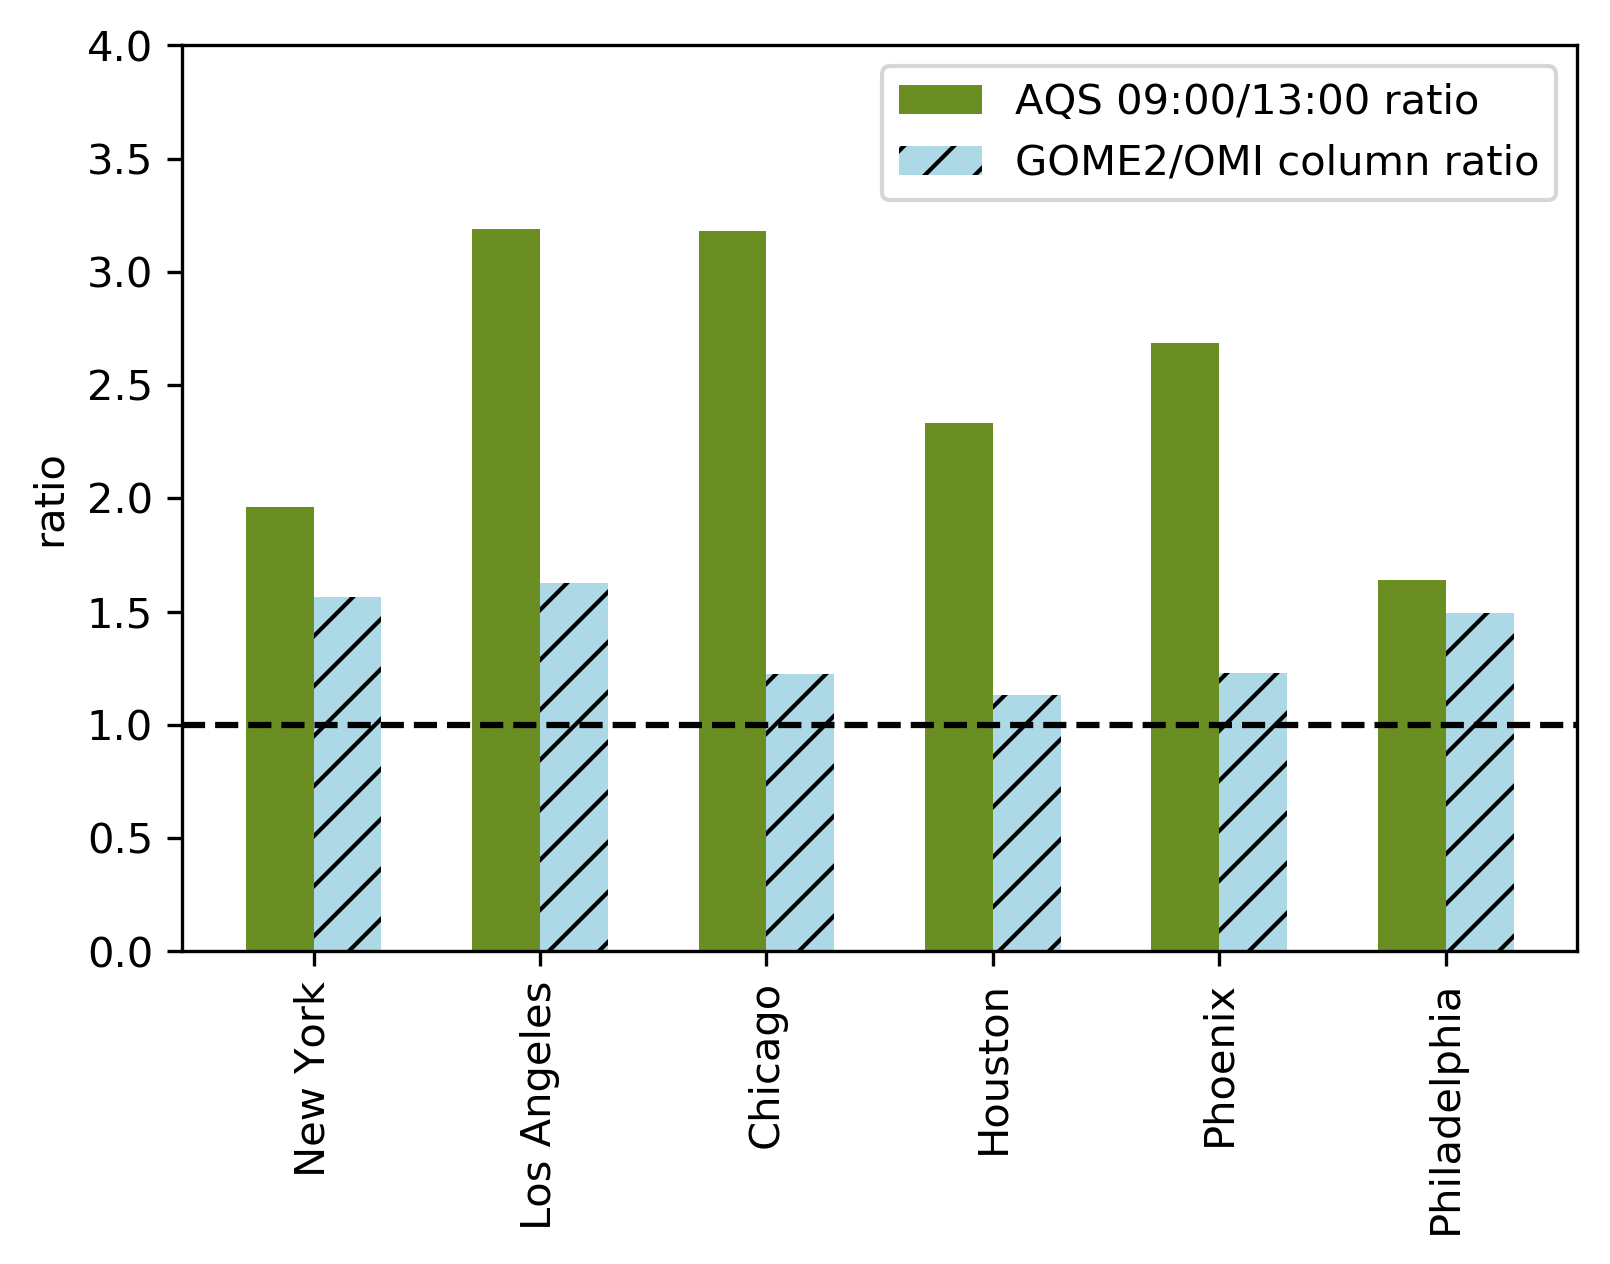

In [41]:
# plot just top 6 cities
bar_plot(aqs_city_avg,cities=top6_cities)

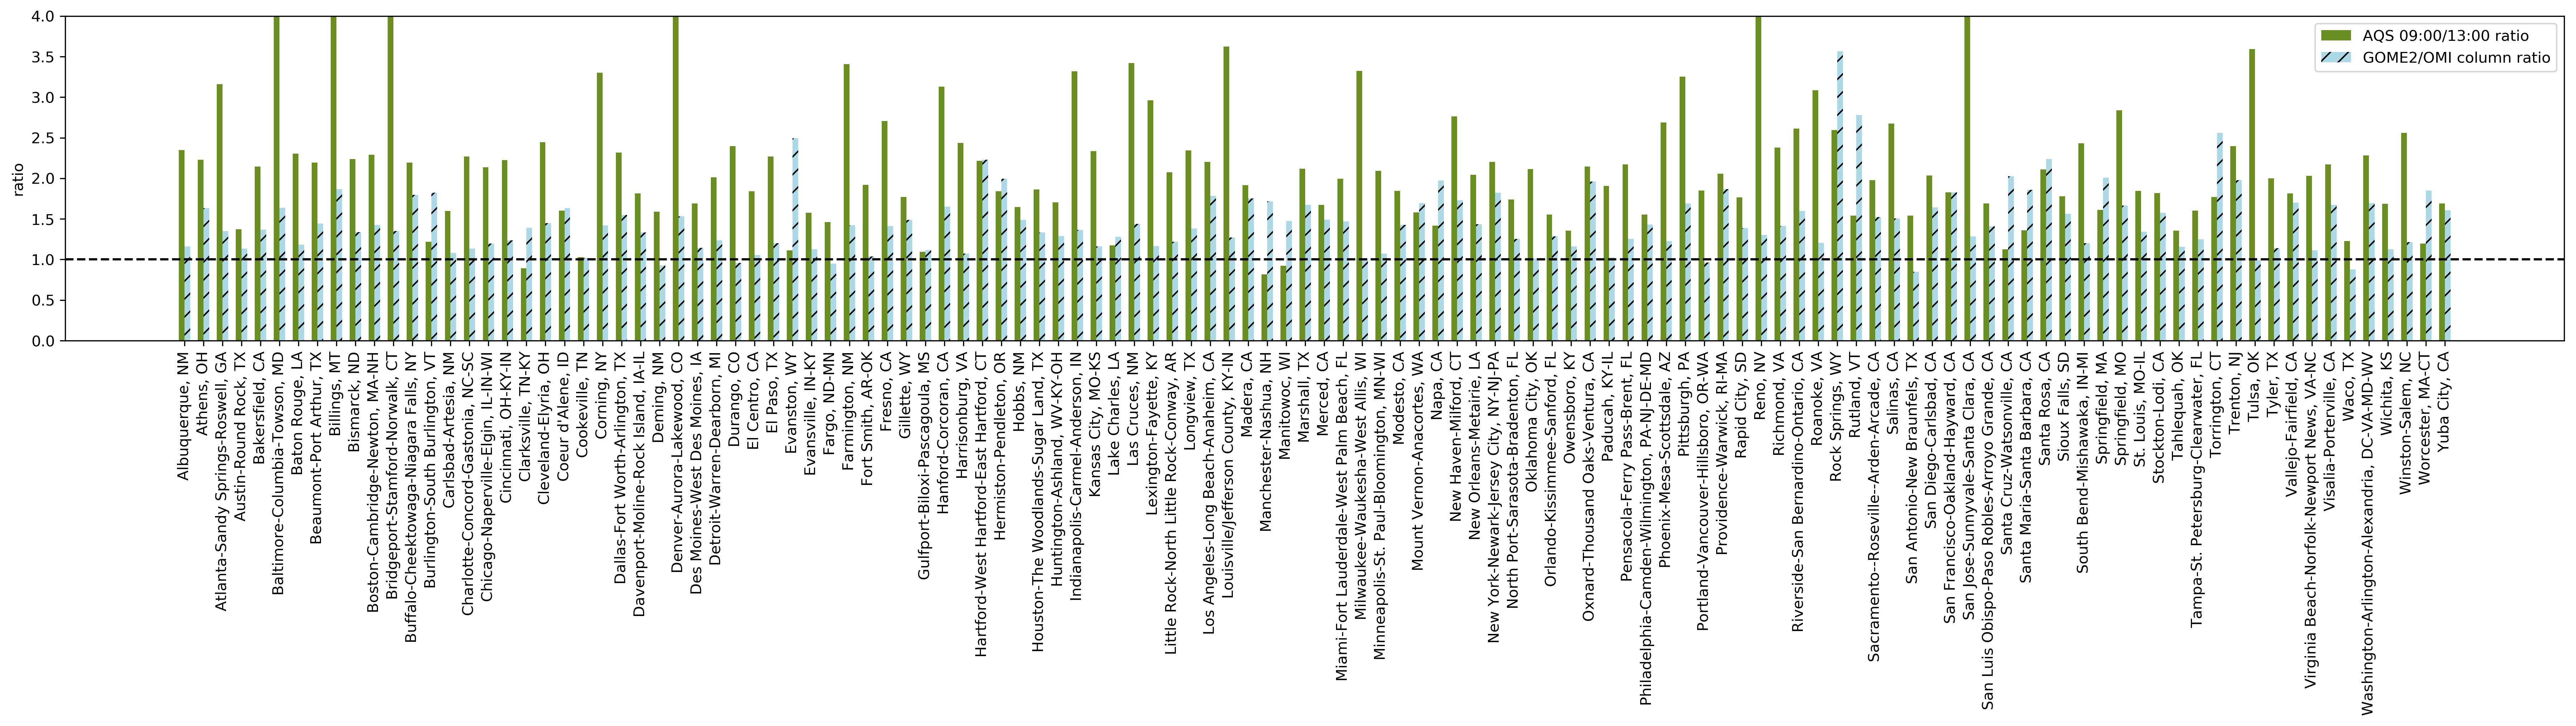

In [42]:
# do it using the CBSAs (?)
# plot all the CBSAs just to show that we can
bar_plot(aqs_cbsa_avg,cities='all',figsize=(30,4))

In [43]:
for i in aqs_cbsa_avg.index:
    print(i)

Albuquerque, NM
Athens, OH
Atlanta-Sandy Springs-Roswell, GA
Austin-Round Rock, TX
Bakersfield, CA
Baltimore-Columbia-Towson, MD
Baton Rouge, LA
Beaumont-Port Arthur, TX
Billings, MT
Bismarck, ND
Boston-Cambridge-Newton, MA-NH
Bridgeport-Stamford-Norwalk, CT
Buffalo-Cheektowaga-Niagara Falls, NY
Burlington-South Burlington, VT
Carlsbad-Artesia, NM
Charlotte-Concord-Gastonia, NC-SC
Chicago-Naperville-Elgin, IL-IN-WI
Cincinnati, OH-KY-IN
Clarksville, TN-KY
Cleveland-Elyria, OH
Coeur d'Alene, ID
Cookeville, TN
Corning, NY
Dallas-Fort Worth-Arlington, TX
Davenport-Moline-Rock Island, IA-IL
Deming, NM
Denver-Aurora-Lakewood, CO
Des Moines-West Des Moines, IA
Detroit-Warren-Dearborn, MI
Durango, CO
El Centro, CA
El Paso, TX
Evanston, WY
Evansville, IN-KY
Fargo, ND-MN
Farmington, NM
Fort Smith, AR-OK
Fresno, CA
Gillette, WY
Gulfport-Biloxi-Pascagoula, MS
Hanford-Corcoran, CA
Harrisonburg, VA
Hartford-West Hartford-East Hartford, CT
Hermiston-Pendleton, OR
Hobbs, NM
Houston-The Woodlands-Sugar

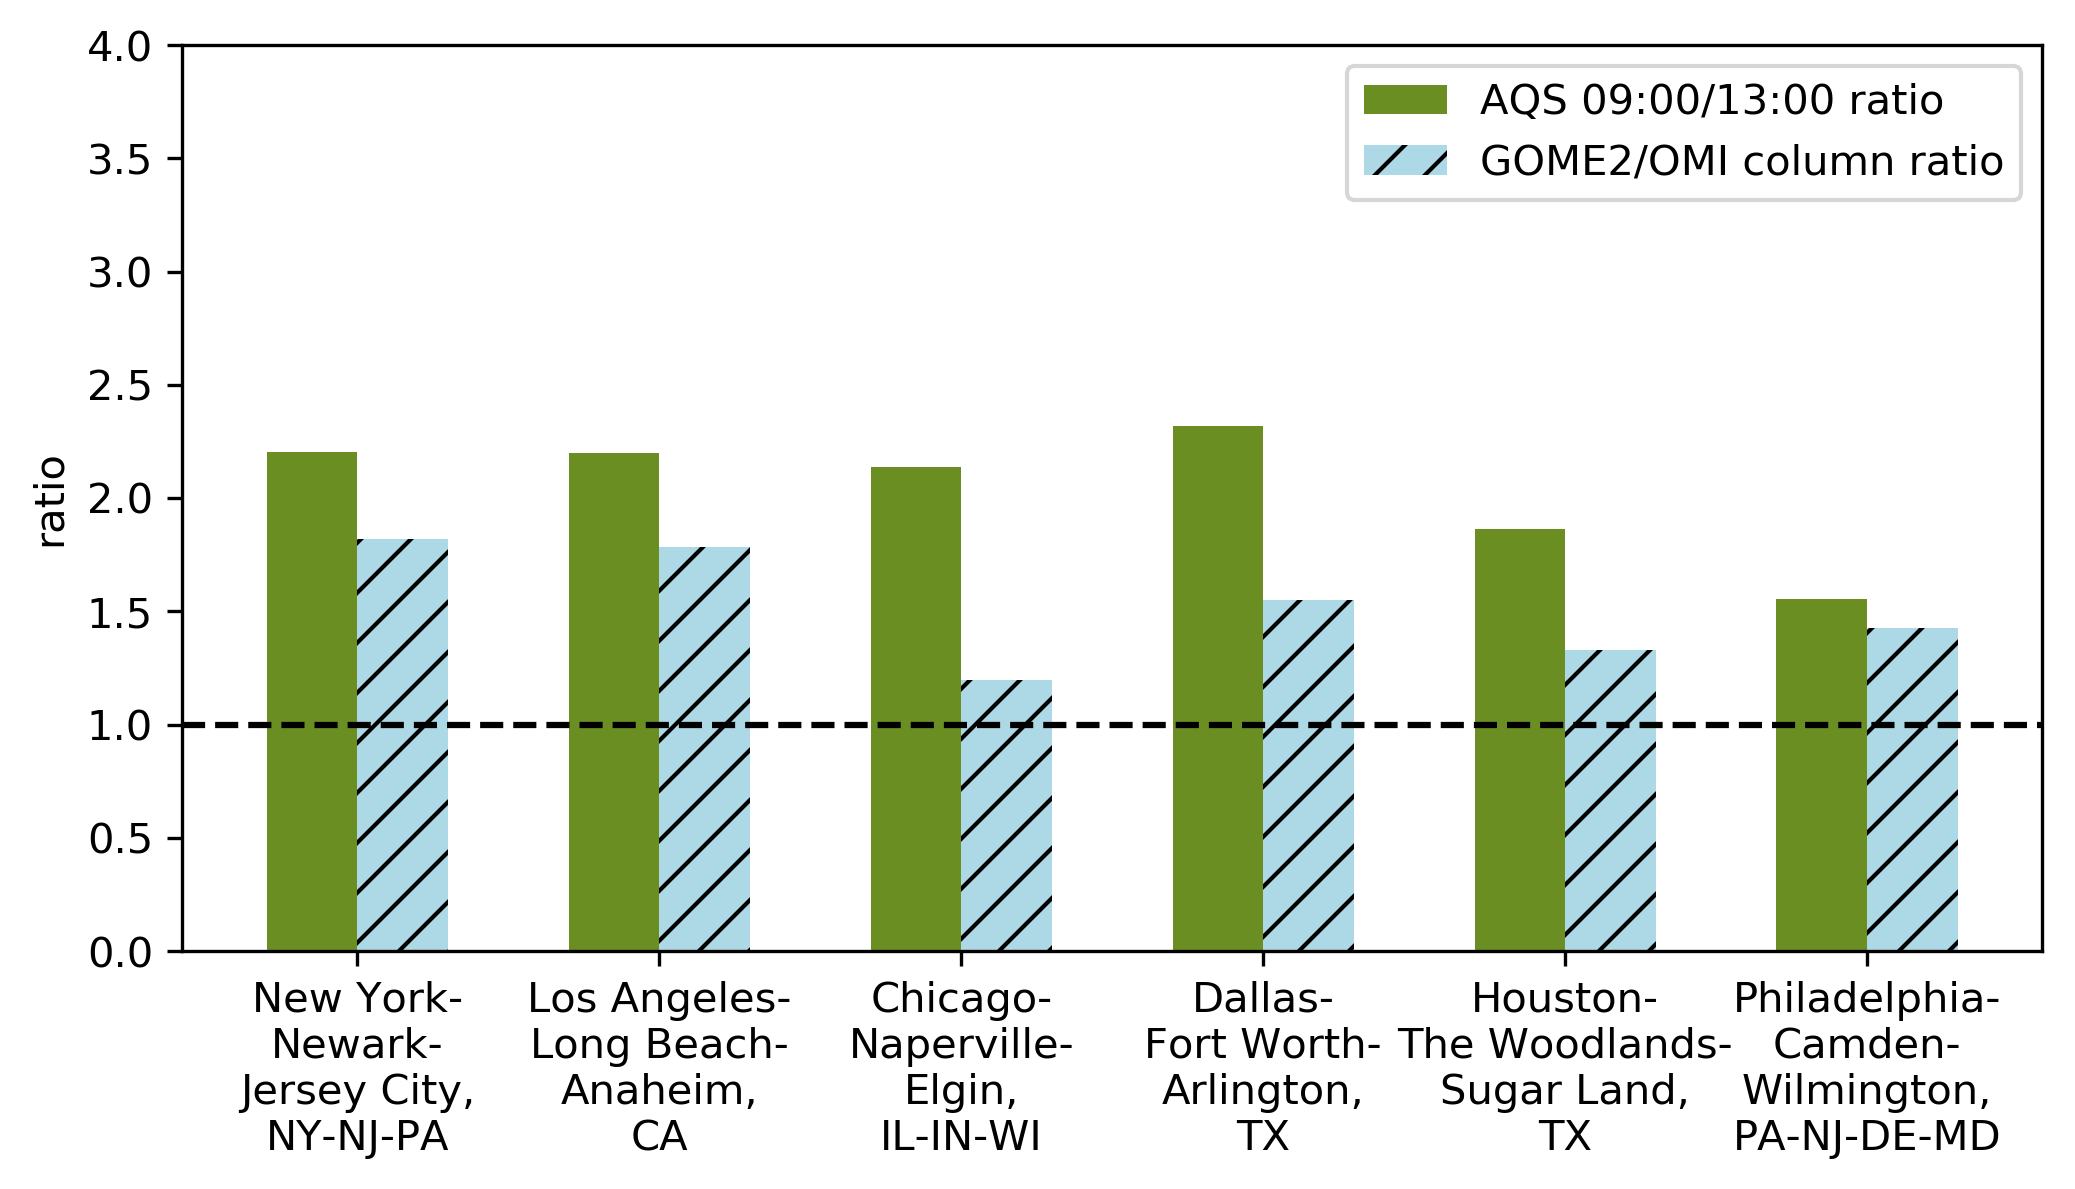

In [44]:
# just top 6 CBSAs
top6_CBSA = ['New York-Newark-Jersey City, NY-NJ-PA', 'Los Angeles-Long Beach-Anaheim, CA',
             'Chicago-Naperville-Elgin, IL-IN-WI', 'Dallas-Fort Worth-Arlington, TX',
             'Houston-The Woodlands-Sugar Land, TX',
             'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD']
#'Phoenix-Mesa-Scottsdale, AZ',
top6_CBSA_labels = ['New York-\nNewark-\nJersey City,\nNY-NJ-PA', 
                    'Los Angeles-\nLong Beach-\nAnaheim,\nCA',
                    'Chicago-\nNaperville-\nElgin,\nIL-IN-WI', 
                    'Dallas-\nFort Worth-\nArlington,\nTX',
                    'Houston-\nThe Woodlands-\nSugar Land,\nTX',
                    'Philadelphia-\nCamden-\nWilmington,\nPA-NJ-DE-MD']
# 'Phoenix-\nMesa-\nScottsdale,\nAZ',  b/t houston an dphiladephia
bar_plot(aqs_cbsa_avg,cities=top6_CBSA,figsize=(8,4),rotation=0,
         labels=top6_CBSA_labels)

## Plot $R^2$ of Each Monitor

In [45]:
def compare_each_monitor(yourDict, keyX, keyY, return_diff=False):
    r2 = np.array([])
    lat = np.array([])
    lon = np.array([])
    diff = np.array([])
    for coordTup, var in yourDict.iteritems():
        varX = var[keyX]
        varY = var[keyY]
        monID = var['ID']
## Southern California
#         if  monID>10.**9. or \
#              np.all([soCalMon!=str(monID)[:4] for soCalMon in soCal]):
#             continue
## Maricopa County
#         if  monID>10.**9. or \
#               str(monID)[:4]!='4013':
#             continue
        mask = ~np.isnan(varX) & ~np.isnan(varY)
        slope, intercept, r_value, p_value, std_err = RMA(varX[mask],varY[mask])
        lat = np.append(lat,coordTup[0])
        lon = np.append(lon,coordTup[1])
        r2 = np.append(r2,r_value**2.)
        nonzero = varY!=0
        diff = np.append(diff,np.nanmean(varX[mask&nonzero]/varY[mask&nonzero]))
        #if r_value**2.>0.3:
        #scatter_plot(varX,varY,slope,intercept,xlabel='aqs',ylabel='sat')
    if return_diff: # return difference (for comparisons between two datasets with the same units)
        return diff, lat, lon
    else: # retun r2 (for datasets with different units)
        return r2, lat, lon

In [46]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [47]:
go2R2, go2Lat, go2Lon = compare_each_monitor(concDict,'go2AQS','go2Sat')
omiR2, omiLat, omiLon = compare_each_monitor(concDict,'omiAQS','omiSat')

/Users/Elise/miniconda2/envs/netcdf/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/Elise/miniconda2/envs/netcdf/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [48]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# plot the r2 at each lat, lon 
bounds = True
lonlim = [-126.,-66.]
latlim = [24.,50.]

# set projection for grid
plate_caree = ccrs.PlateCarree()

# set size of figure, in inches
figX = 8.5
figY = 11

# adjust the colormap we're using for NO2
minColor = 0.05
maxColor = 1.0
cmap_t = truncate_colormap(plt.get_cmap("nipy_spectral_r"), minColor, maxColor)
colormap = cmap_t

# settings for the NO2 norm
minvalue = 0.
maxvalue = 1.1
delta = 0.2
no2Boundaries = np.arange(minvalue,maxvalue,delta)
norm = mcolors.BoundaryNorm(boundaries=no2Boundaries, ncolors=colormap.N)

# set up NO2 tick lables and add '<' and '>' to first and last items
no2Ticks = np.linspace(no2Boundaries[0],no2Boundaries[-1],6)
no2TickLabels = [format(x,'.2f') for x in no2Ticks]

states_provinces = cfeature.NaturalEarthFeature(
                    category='cultural',
                    name='admin_1_states_provinces_lines',
                    scale='10m',
                    facecolor='none')

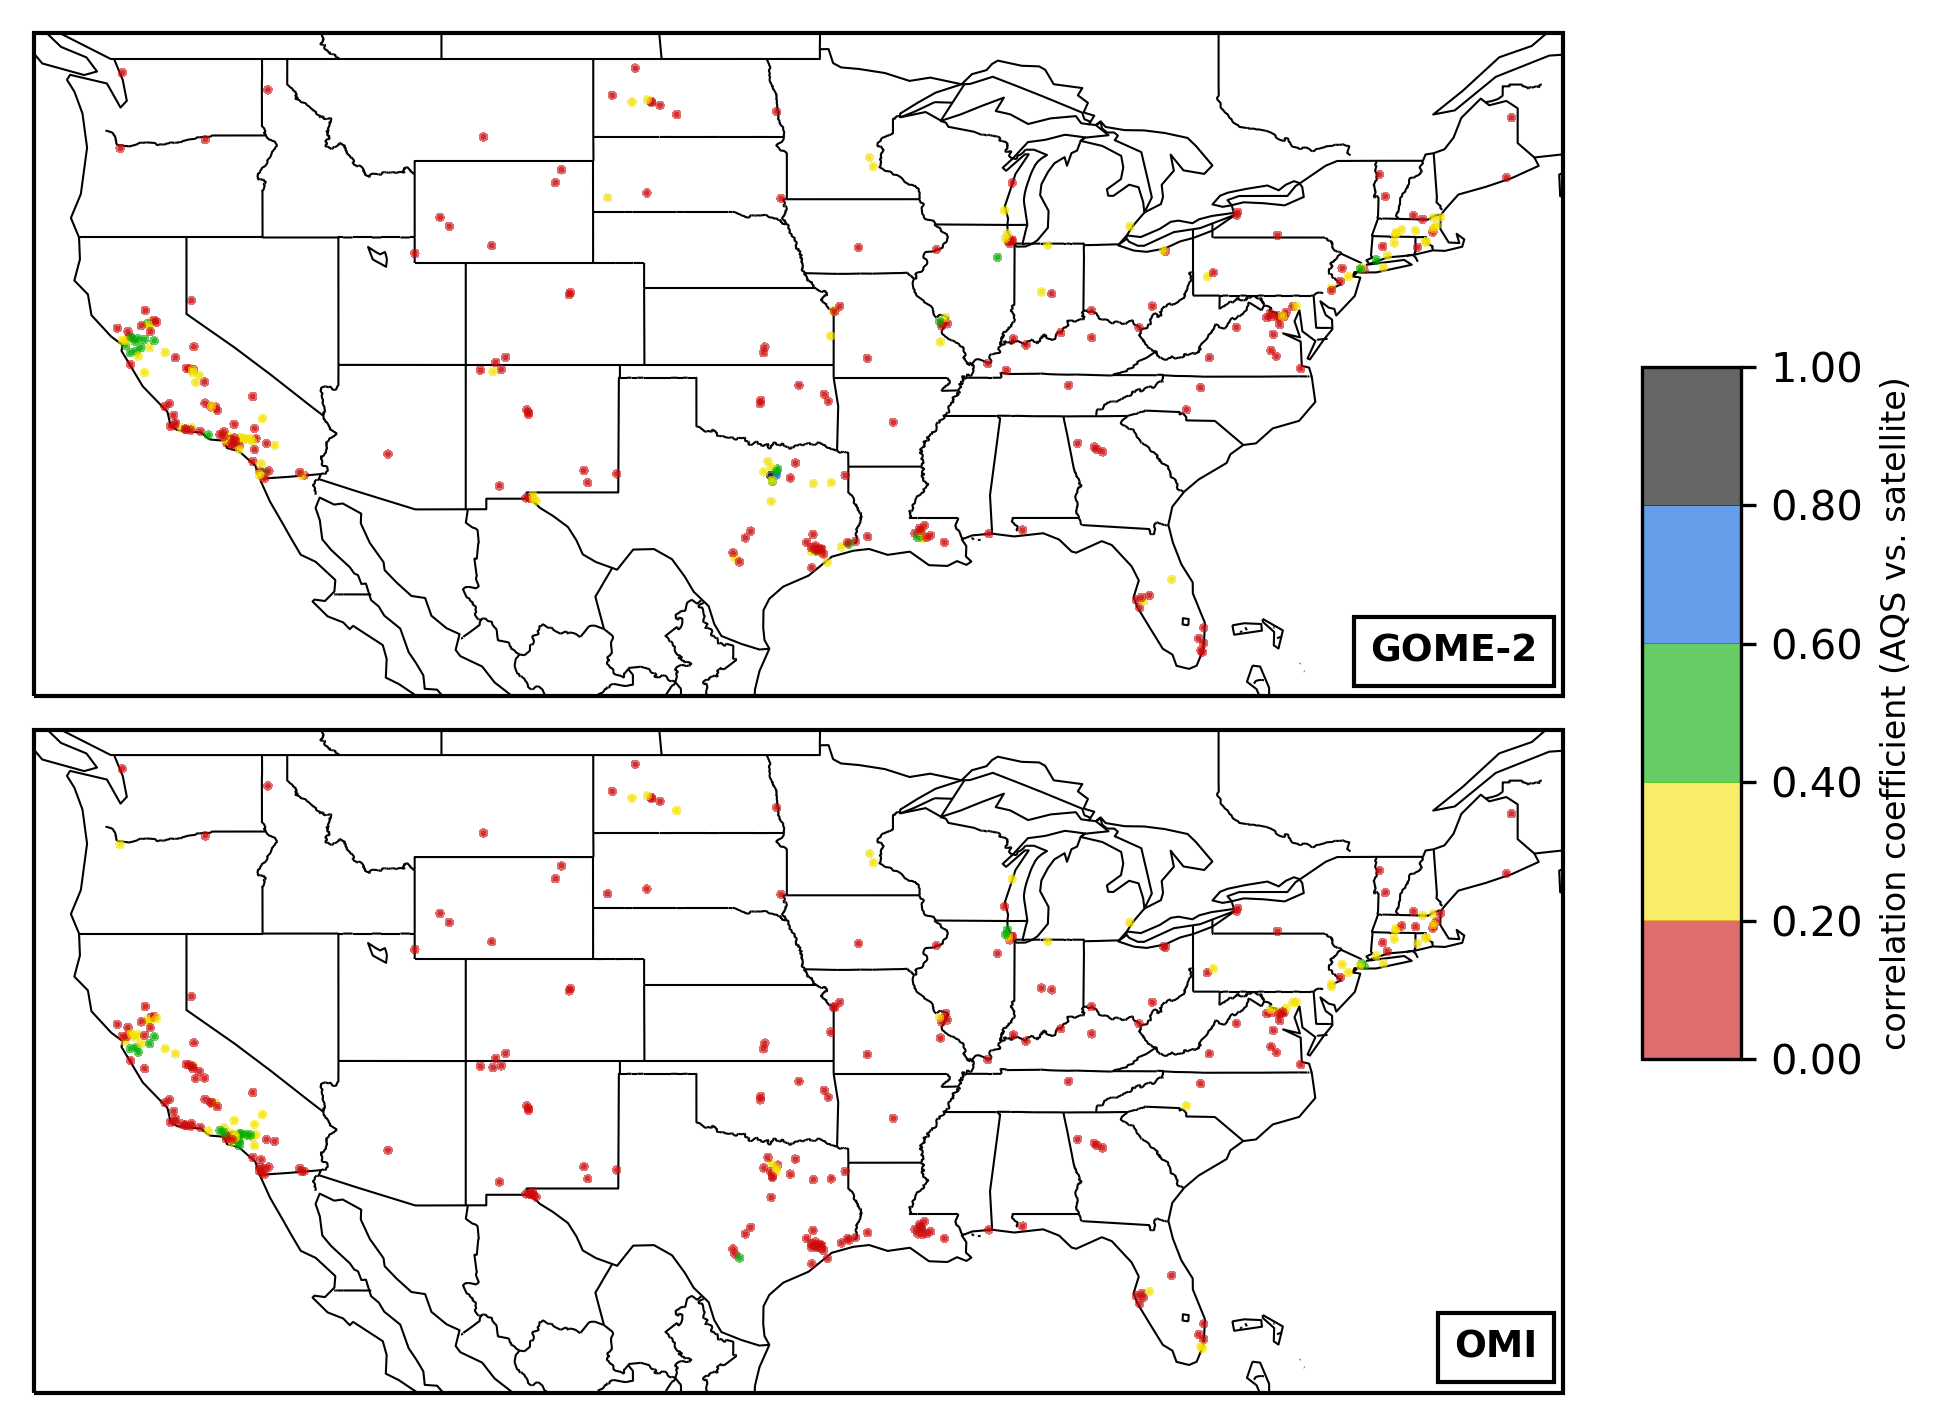

In [49]:
figBoth, (axG,axO) = plt.subplots(nrows=2, ncols=1, sharex='all', sharey='all',
                                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        gridspec_kw={'hspace':0.05}, figsize=(8.5,6), dpi=300) #figsize=(figX,figY)


# plot GOME-2
go2Plot = axG.scatter(go2Lon, go2Lat, c=go2R2, s=1, alpha=0.6, transform=plate_caree, 
               cmap=colormap, norm=norm, antialiased=False, zorder=10)
axG.add_feature(cfeature.COASTLINE,zorder=5, linewidth=0.5)
axG.add_feature(cfeature.BORDERS,zorder=4, linewidth=0.5)
axG.add_feature(cfeature.LAKES,edgecolor='black', zorder=6,facecolor='None', linewidth=0.5)
#axG.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
axG.add_feature(states_provinces, edgecolor='black', zorder = 4, linewidth=0.5)
axG.text(0.983,0.04, 'GOME-2', verticalalignment='bottom', horizontalalignment='right',
         transform=axG.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

# plot OMI
omiPlot = axO.scatter(omiLon, omiLat, c=omiR2, s=1, alpha=0.6, transform=plate_caree, 
               cmap=colormap, norm=norm, antialiased=False, zorder=10)
axO.add_feature(cfeature.COASTLINE,zorder=5, linewidth=0.5)
axO.add_feature(cfeature.BORDERS,zorder=4, linewidth=0.5)
axO.add_feature(cfeature.LAKES,edgecolor='black', zorder=6,facecolor='None',linewidth=0.5)
#axO.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
axO.add_feature(states_provinces, edgecolor='black', zorder = 4,linewidth=0.5)
axO.text(0.983,0.04, 'OMI', verticalalignment='bottom', horizontalalignment='right',
         transform=axO.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

if bounds:
    axG.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    axO.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    
# set up colorbars
no2Cbar = figBoth.colorbar(omiPlot, orientation='vertical', ax=[axG,axO],
                 fraction=0.050, pad=0.04, aspect=7, ticks=no2Ticks)
# Manually assign tickmarks. Add > and < to first and last label.
no2Cbar.ax.set_yticklabels(no2TickLabels)
# add titles to both cbars
no2Cbar.ax.set_ylabel('correlation coefficient (AQS vs. satellite)',fontsize=8)


#figBoth.set_size_inches(figX,figY)

plt.show()

In [50]:
np.nanmax(omiR2)

0.5945158655679964

## Plot difference for each monitor

In [51]:
diff, lat, lon = compare_each_monitor(concDict,'go2AQS','omiAQS',return_diff=True)

In [52]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# plot the r2 at each lat, lon 
bounds = True
lonlim = [-126.,-66.]
latlim = [24.,50.]

# set projection for grid
plate_caree = ccrs.PlateCarree()

# set size of figure, in inches
figX = 8.5
figY = 11

# adjust the colormap we're using for NO2
minColor = 0.0
maxColor = 1.0
cmap_t = truncate_colormap(plt.get_cmap("RdBu_r"), minColor, maxColor)
colormap = cmap_t

# settings for the NO2 norm
minvalue = 0.
maxvalue = 2.1
delta = 0.25
no2Boundaries = np.arange(minvalue,maxvalue,delta)
norm = mcolors.BoundaryNorm(boundaries=no2Boundaries, ncolors=colormap.N)

# set up NO2 tick lables and add '<' and '>' to first and last items
no2Ticks = np.linspace(no2Boundaries[0],no2Boundaries[-1],7)
no2TickLabels = [format(x,'.2f') for x in no2Ticks]

states_provinces = cfeature.NaturalEarthFeature(
                    category='cultural',
                    name='admin_1_states_provinces_lines',
                    scale='10m',
                    facecolor='none')

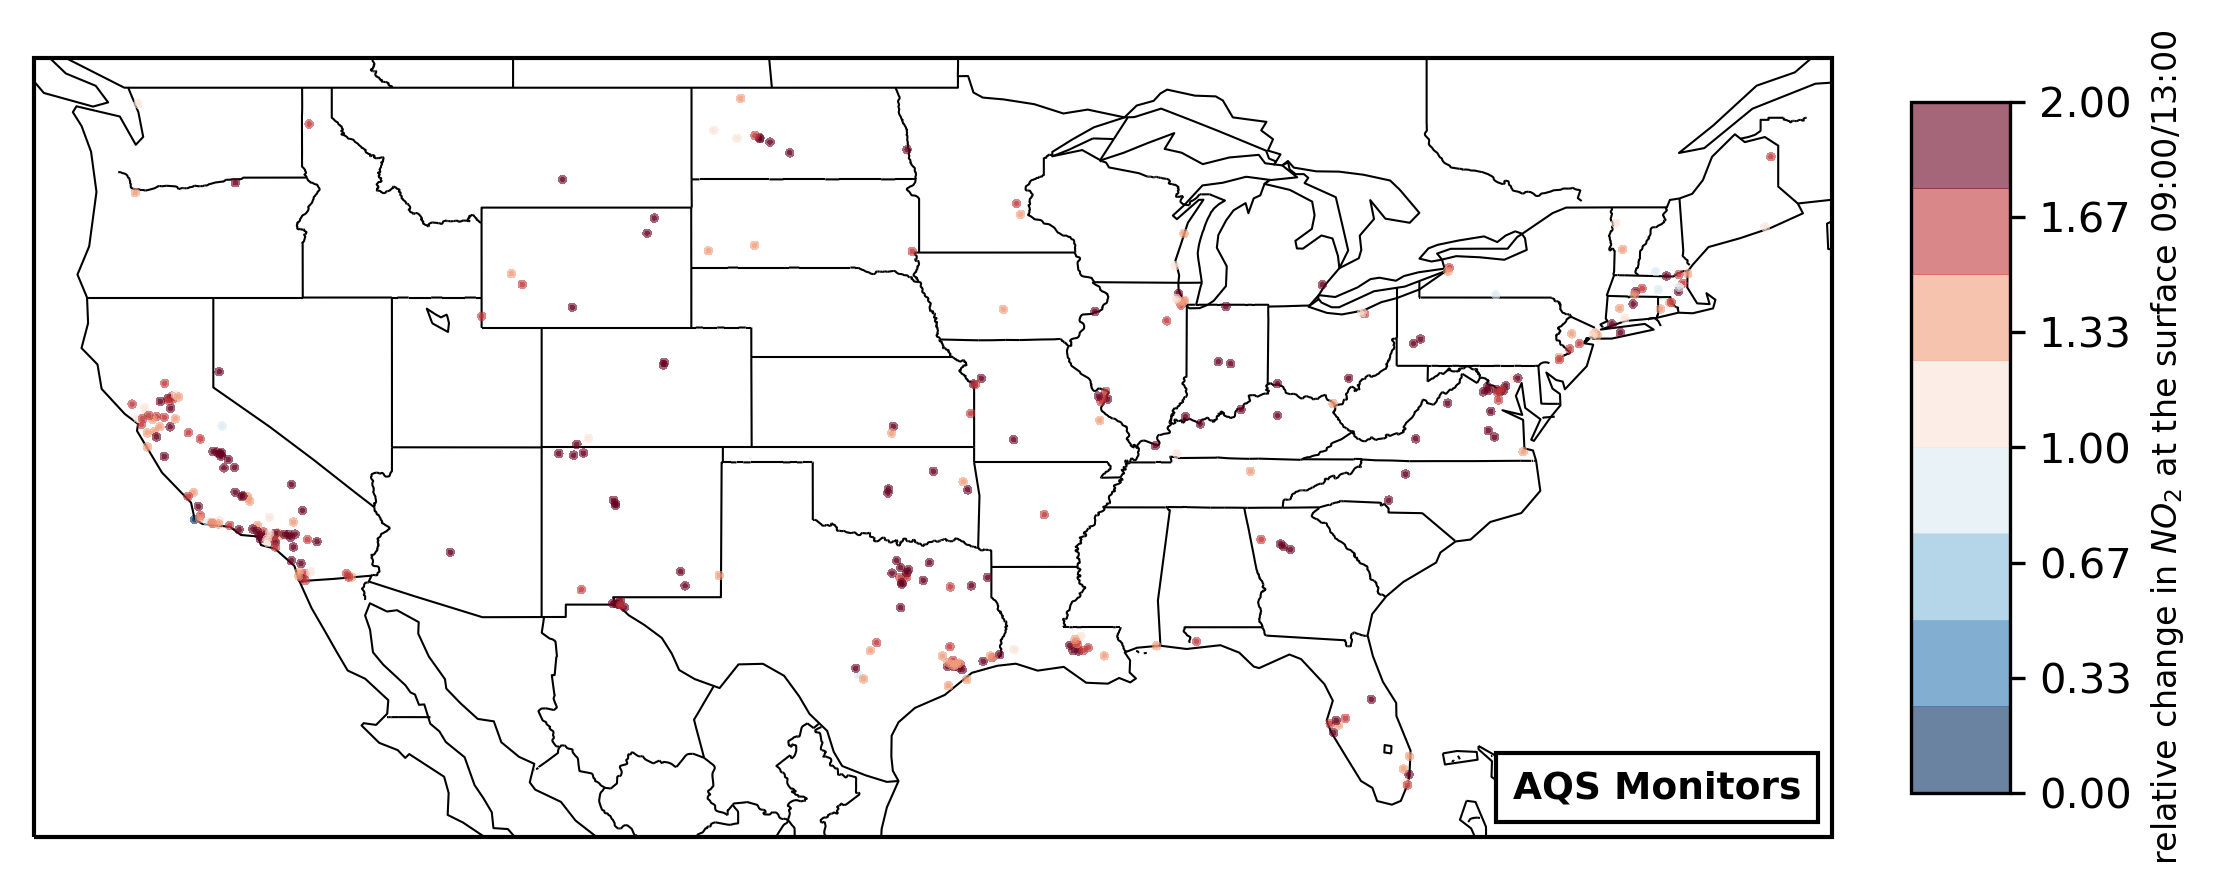

In [53]:
figBoth, ax = plt.subplots(nrows=1, ncols=1, sharex='all', sharey='all',
                                        subplot_kw={'projection': ccrs.PlateCarree()}, 
                                        gridspec_kw={'hspace':0.05}, figsize=(8.5,6), dpi=300) #figsize=(figX,figY)


# plot GOME-2 - OMI
plot = ax.scatter(lon, lat, c=diff, s=1, alpha=0.6, transform=plate_caree, 
               cmap=colormap, norm=norm, antialiased=False, zorder=10)
ax.add_feature(cfeature.COASTLINE,zorder=5, linewidth=0.5)
ax.add_feature(cfeature.BORDERS,zorder=4, linewidth=0.5)
ax.add_feature(cfeature.LAKES,edgecolor='black', zorder=6,facecolor='None', linewidth=0.5)
#ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=4)
ax.add_feature(states_provinces, edgecolor='black', zorder = 4, linewidth=0.5)
ax.text(0.983,0.04, 'AQS Monitors', verticalalignment='bottom', horizontalalignment='right',
         transform=ax.transAxes, fontweight='bold', fontsize=9, zorder=99,
         bbox=dict(facecolor='white', edgecolor='black', alpha=1))

if bounds:
    ax.set_extent([lonlim[0],lonlim[1],latlim[0],latlim[1]], crs=ccrs.PlateCarree())
    
# set up colorbars
no2Cbar = figBoth.colorbar(plot, orientation='vertical', ax=ax,
                 fraction=0.050, pad=0.04, aspect=7, ticks=no2Ticks)
# Manually assign tickmarks. Add > and < to first and last label.
no2Cbar.ax.set_yticklabels(no2TickLabels)
# add titles to both cbars
no2Cbar.ax.set_ylabel('relative change in $NO_2$ at the surface 09:00/13:00',fontsize=8)


#figBoth.set_size_inches(figX,figY)

plt.show()